# Section 2

This notebook presents the analysis relevant for the Section 2 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logits ~ Energy

In [2]:
## Functions moved to utils_07. Can be refactored.

from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

def task_generator(task_types=task_types, loader=loader, seed_split_ids=None):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    if seed_split_ids is None:
        seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    else:
        seed_split_ids = seed_split_ids
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task


def get_miniabsolut_dataframes(task, load_energy_contributions=False):
    """Load the dataframes based on MiniAbsolut, from task
    These dataframes contain extra info, such as binding energies.
    """
    if task.split_id == 42:
        miniabsolut_path = Path("../data/MiniAbsolut")
    elif task.split_id in [0, 1, 2, 3, 4]:
        miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed{task.split_id}")
    
    ag_pos_dir = miniabsolut_path / task.ag_pos
    if load_energy_contributions:
        ag_pos_dir = ag_pos_dir / "energy_contributions"
        suffix = "_absolut_energy_contributions"
        header = 1
    else:
        suffix = ""
        header = 0

    fn = list(ag_pos_dir.glob(f"high_test_[0-9]*{suffix}.tsv"))[0]
    df_pos = pd.read_csv(fn, sep="\t", header=header)
    df_pos["class"] = "positive"

    if task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
        fn = list(ag_pos_dir.glob(f"95low_test_[0-9]*{suffix}.tsv"))[0]
        df_neg = pd.read_csv(fn, sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        fn = list(ag_pos_dir.glob(f"looserX_test_[0-9]*{suffix}.tsv"))[0]
        df_neg = pd.read_csv(fn, sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type in (datasets.ClassificationTaskType.ONE_VS_ONE, datasets.ClassificationTaskType.ONE_VS_NINE):
        # raise ValueError("Not implemented.")
        df_neg = pd.DataFrame()
    
    df = pd.concat([df_pos, df_neg], axis=0)
    
    return df

In [3]:
logit_energy_corr_path = "../data/Frozen_MiniAbsolut_ML/LogitEnergyCorrelations.tsv"
force_run = True
skip_errors_logits = True

if Path(logit_energy_corr_path).exists() and not force_run:
    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
else:

    records = []
    for task in task_generator():
        
        if skip_errors_logits:
            try:
                task = loader.load(task, attributions_toload="Test")
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="Test")

        # Get energies
        df = get_miniabsolut_dataframes(task)

        # Add logits to df
        df_attr = pd.DataFrame.from_records(task.attributions)
        df = pd.merge(df, df_attr[["slide", "logits"]], left_on="Slide", right_on="slide", how='left')

        # Compute correlation and p-val with scipy for all and positive class
        r, p = pearsonr(df["logits"], df["Energy"])
        r_pos, p_pos = pearsonr(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"])

        # Compute slope for all and positive class
        slope, intercept = np.polyfit(df["logits"], df["Energy"], 1)
        slope_pos, intercept_pos = np.polyfit(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"], 1)
        
        records.append({
            "task_type": task.task_type.to_str(),
            "ag_pos": task.ag_pos,
            "ag_neg": task.ag_neg,
            "seed_id": task.seed_id,
            "split_id": task.split_id,
            "r": r,
            "p": p,
            "r2": r**2,
            "r_pos": r_pos,
            "r_pos2": r_pos**2,
            "p_pos": p_pos,
            "slope": slope,
            "intercept": intercept,
            "slope_pos": slope_pos,
            "intercept_pos": intercept_pos,
            "logits_mean": df["logits"].mean(),
            "logits_std": df["logits"].std(),
            "Energy_mean": df["Energy"].mean(),
            "Energy_std": df["Energy"].std(),
            "logits_pos_mean": df[df["class"] == "positive"]["logits"].mean(),
            "logits_pos_std": df[df["class"] == "positive"]["logits"].std(),
            "Energy_pos_mean": df[df["class"] == "positive"]["Energy"].mean(),
            "Energy_pos_std": df[df["class"] == "positive"]["Energy"].std(),
            "logits_neg_mean": df[df["class"] == "negative"]["logits"].mean(),
            "logits_neg_std": df[df["class"] == "negative"]["logits"].std(),
            "Energy_neg_mean": df[df["class"] == "negative"]["Energy"].mean(),
            "Energy_neg_std": df[df["class"] == "negative"]["Energy"].std(),
        })

    df_logits = pd.DataFrame.from_records(records)
    df_logits.to_csv(logit_energy_corr_path, index=False, sep='\t')

In [4]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
1v1            -0.781997 -0.010498  0.824404
1v9            -0.390399 -0.015804  0.625707
high_vs_95low  -0.653176 -0.172293  0.721793
high_vs_looser -0.668152 -0.080362  0.393446

/tmp/ipykernel_317905/3822063044.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

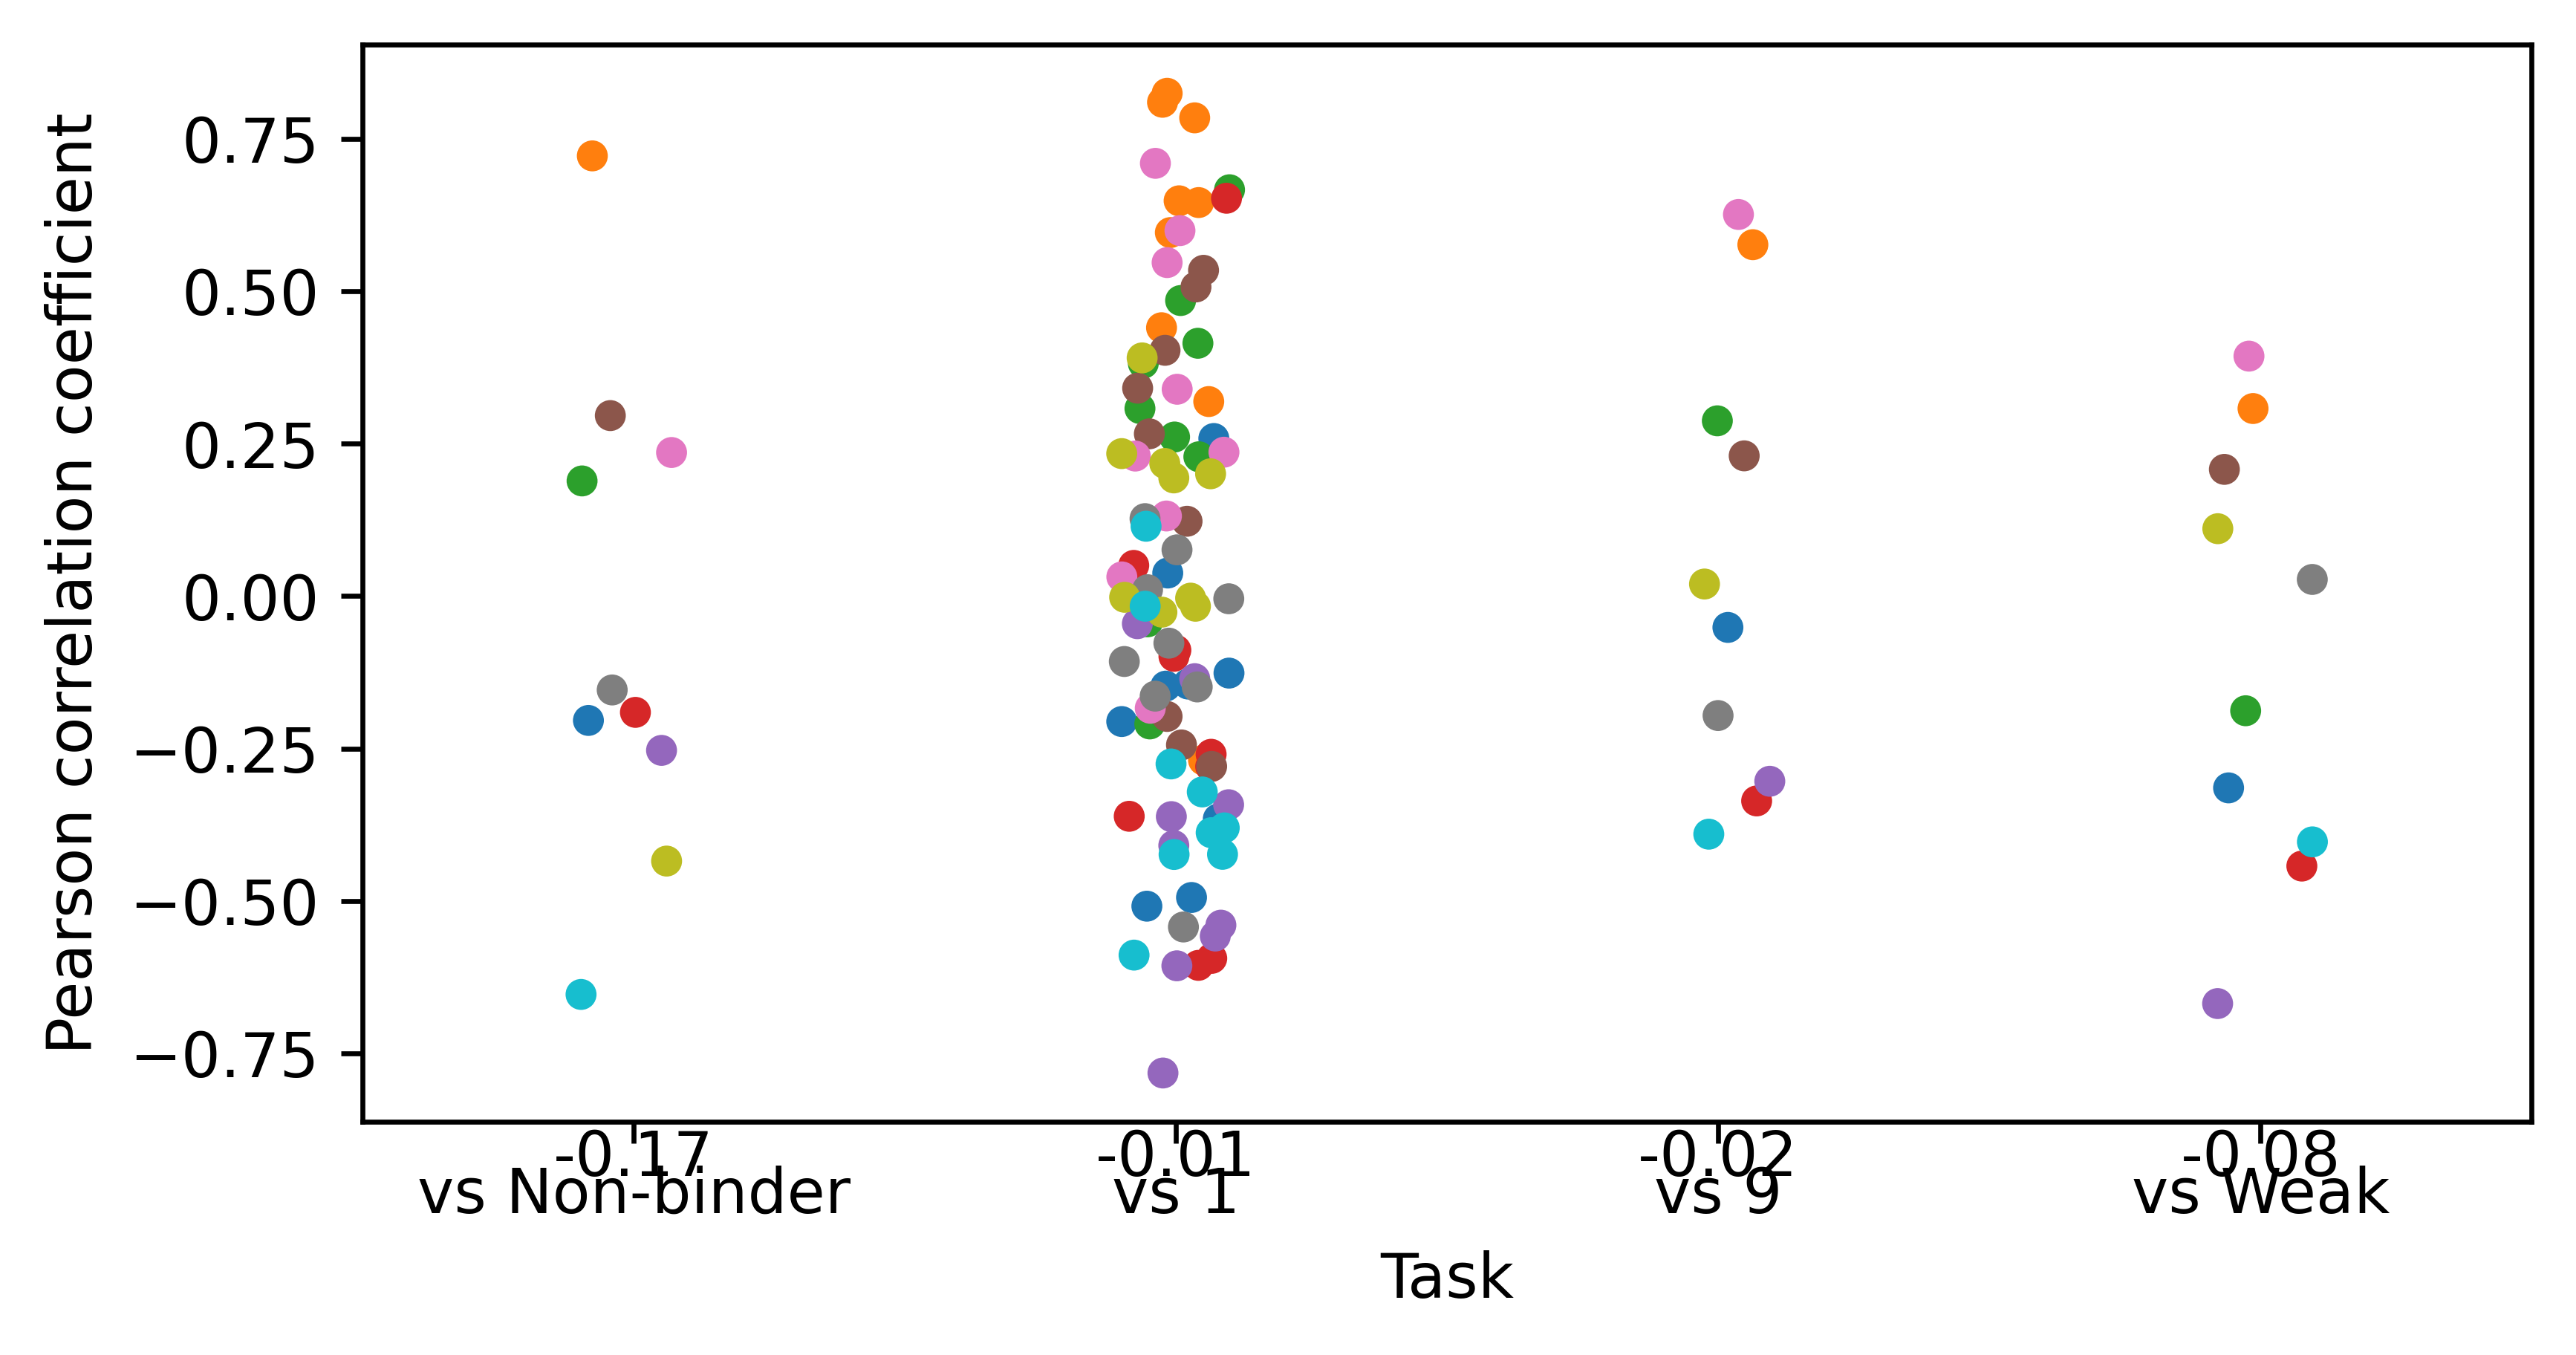

In [5]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos", 
    hue="ag_pos", 
    ax=ax, 
    # cmap=visualisations.PlotParams.cmap_antigens,
    order=task_order,
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.95,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [6]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_logits.query("task_type == 'high_vs_95low'")["r_pos"],
    df_logits.query("task_type == '1v1'")["r_pos"],
    df_logits.query("task_type == '1v9'")["r_pos"],
    df_logits.query("task_type == 'high_vs_looser'")["r_pos"],
)

F_onewayResult(statistic=0.3810781277117555, pvalue=0.7668208386006647)

In [7]:
df_logits

,task_type,ag_pos,ag_neg,seed_id,split_id,r,p,r2,r_pos,r_pos2,...,Energy_mean,Energy_std,logits_pos_mean,logits_pos_std,Energy_pos_mean,Energy_pos_std,logits_neg_mean,logits_neg_std,Energy_neg_mean,Energy_neg_std
0,1v1,3VRL,1NSN,0,42,-0.494191,1.465363e-01,0.244225,-0.494191,0.244225,...,-97.6640,1.153605,0.928894,1.067781,-97.664,1.153605,NaN,NaN,NaN,NaN
1,1v1,3VRL,3RAJ,0,42,-0.126273,7.281399e-01,0.015945,-0.126273,0.015945,...,-97.6640,1.153605,0.603957,1.260969,-97.664,1.153605,NaN,NaN,NaN,NaN
2,1v1,3VRL,5E94,0,42,-0.205724,5.685455e-01,0.042322,-0.205724,0.042322,...,-97.6640,1.153605,1.002275,1.136591,-97.664,1.153605,NaN,NaN,NaN,NaN
3,1v1,3VRL,1H0D,0,42,-0.147642,6.839811e-01,0.021798,-0.147642,0.021798,...,-97.6640,1.153605,0.735699,0.949598,-97.664,1.153605,NaN,NaN,NaN,NaN
4,1v1,3VRL,1WEJ,0,42,-0.144217,6.910057e-01,0.020798,-0.144217,0.020798,...,-97.6640,1.153605,0.509189,0.849507,-97.664,1.153605,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,high_vs_95low,2YPV,auto,0,42,-0.912595,2.051943e-08,0.832830,-0.434505,0.188795,...,-87.9265,9.872597,1.396465,0.605291,-96.814,1.203054,-0.533817,0.605429,-79.039,5.365694
116,high_vs_looser,2YPV,auto,0,42,-0.221692,3.475468e-01,0.049147,0.110497,0.012210,...,-94.6660,2.425710,0.867868,0.745063,-96.814,1.203054,0.363092,0.925934,-92.518,0.849389
117,1v9,1OB1,auto,0,42,-0.390399,2.646904e-01,0.152411,-0.390399,0.152411,...,-94.5120,1.788661,1.306599,1.062787,-94.512,1.788661,NaN,NaN,NaN,NaN
118,high_vs_95low,1OB1,auto,0,42,-0.862248,1.017752e-06,0.743471,-0.653176,0.426640,...,-85.4100,9.827531,1.132128,0.687310,-94.512,1.788661,-0.692693,0.552752,-76.308,4.073014


In [8]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"
df_acc = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')

records = []
for i, row in df_acc.iterrows():
    try:
        task_str = row["task"]
    except:
        print(row)
        raise
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df_acc = pd.merge(df_acc, pd.DataFrame(records), on="task")

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df_acc["task_type_clean"] = df_acc["task_type"].map(map_task_type_to_clean)
df_acc["acc_closed"] = df_acc["acc"].astype(float)

df_acc

,task,N_pos,N_neg,acc,recall,precision,f1,ag_pos,ag_neg,seed_id,split_id,task_type,task_type_clean,acc_closed
0,HIGH_VS_95LOW__3VRL__auto__1__42,10,10,0.80,0.7,0.875000,0.777778,3VRL,auto,1,42,high_vs_95low,vs Non-binder,0.80
1,HIGH_VS_LOOSER__3VRL__auto__1__42,10,10,0.60,0.4,0.666667,0.500000,3VRL,auto,1,42,high_vs_looser,vs Weak,0.60
2,ONE_VS_NINE__3VRL__auto__1__42,10,10,0.80,0.7,0.875000,0.777778,3VRL,auto,1,42,1v9,vs 9,0.80
3,HIGH_VS_95LOW__3VRL__auto__2__42,10,10,0.80,0.7,0.875000,0.777778,3VRL,auto,2,42,high_vs_95low,vs Non-binder,0.80
4,HIGH_VS_LOOSER__3VRL__auto__2__42,10,10,0.55,0.4,0.571429,0.470588,3VRL,auto,2,42,high_vs_looser,vs Weak,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,HIGH_VS_LOOSER__1OB1__auto__0__3,10,10,0.55,0.5,0.555556,0.526316,1OB1,auto,0,3,high_vs_looser,vs Weak,0.55
1073,ONE_VS_NINE__1OB1__auto__0__3,10,10,0.50,0.6,0.500000,0.545455,1OB1,auto,0,3,1v9,vs 9,0.50
1074,HIGH_VS_95LOW__1OB1__auto__0__4,10,10,0.95,1.0,0.909091,0.952381,1OB1,auto,0,4,high_vs_95low,vs Non-binder,0.95
1075,HIGH_VS_LOOSER__1OB1__auto__0__4,10,10,0.65,0.7,0.636364,0.666667,1OB1,auto,0,4,high_vs_looser,vs Weak,0.65


In [9]:
# Define a task column. If task_type 1v1, then ag_pos, ag_neg follow alphanumeric sorting.
def define_task_col(df):
    tasks = []
    for i, row in df.iterrows():
        if row["task_type"] == "1v1":
            ag_1, ag_2 = tuple(sorted([row["ag_pos"], row["ag_neg"]]))
        else:
            ag_1 = row["ag_pos"]
            ag_2 = row["ag_neg"]
        
        if "_" in ag_1:
            ag_1 = ag_1.split("_")[0]

        if "_" in ag_2:
            ag_2 = ag_2.split("_")[0]
        
        if row["task_type"] == "1v9":
            ag_2 = "v9"
        elif ag_2 == "auto" and row["task_type"] != "1v9":
            ag_2 = ag_1

        task = f"{row['task_type']}_{ag_1}_{ag_2}"
        tasks.append(task)

    df["task"] = tasks


define_task_col(df_logits)
define_task_col(df_acc)

In [10]:
# Aggregate acc based on task
df_acc_agg = df_acc.groupby(["task", "task_type"]).agg({"acc_closed": "mean"}).reset_index()

# Aggregate logits correlation based on task
df_logits_agg = df_logits.groupby(["task", "task_type"]).agg({"r_pos": "mean"}).reset_index()

# Merge
df_merged = pd.merge(df_acc_agg, df_logits_agg, on=["task", "task_type"], how='inner')

vs 1
vs 9
vs Non-binder
vs Weak


/tmp/ipykernel_317905/3365303078.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


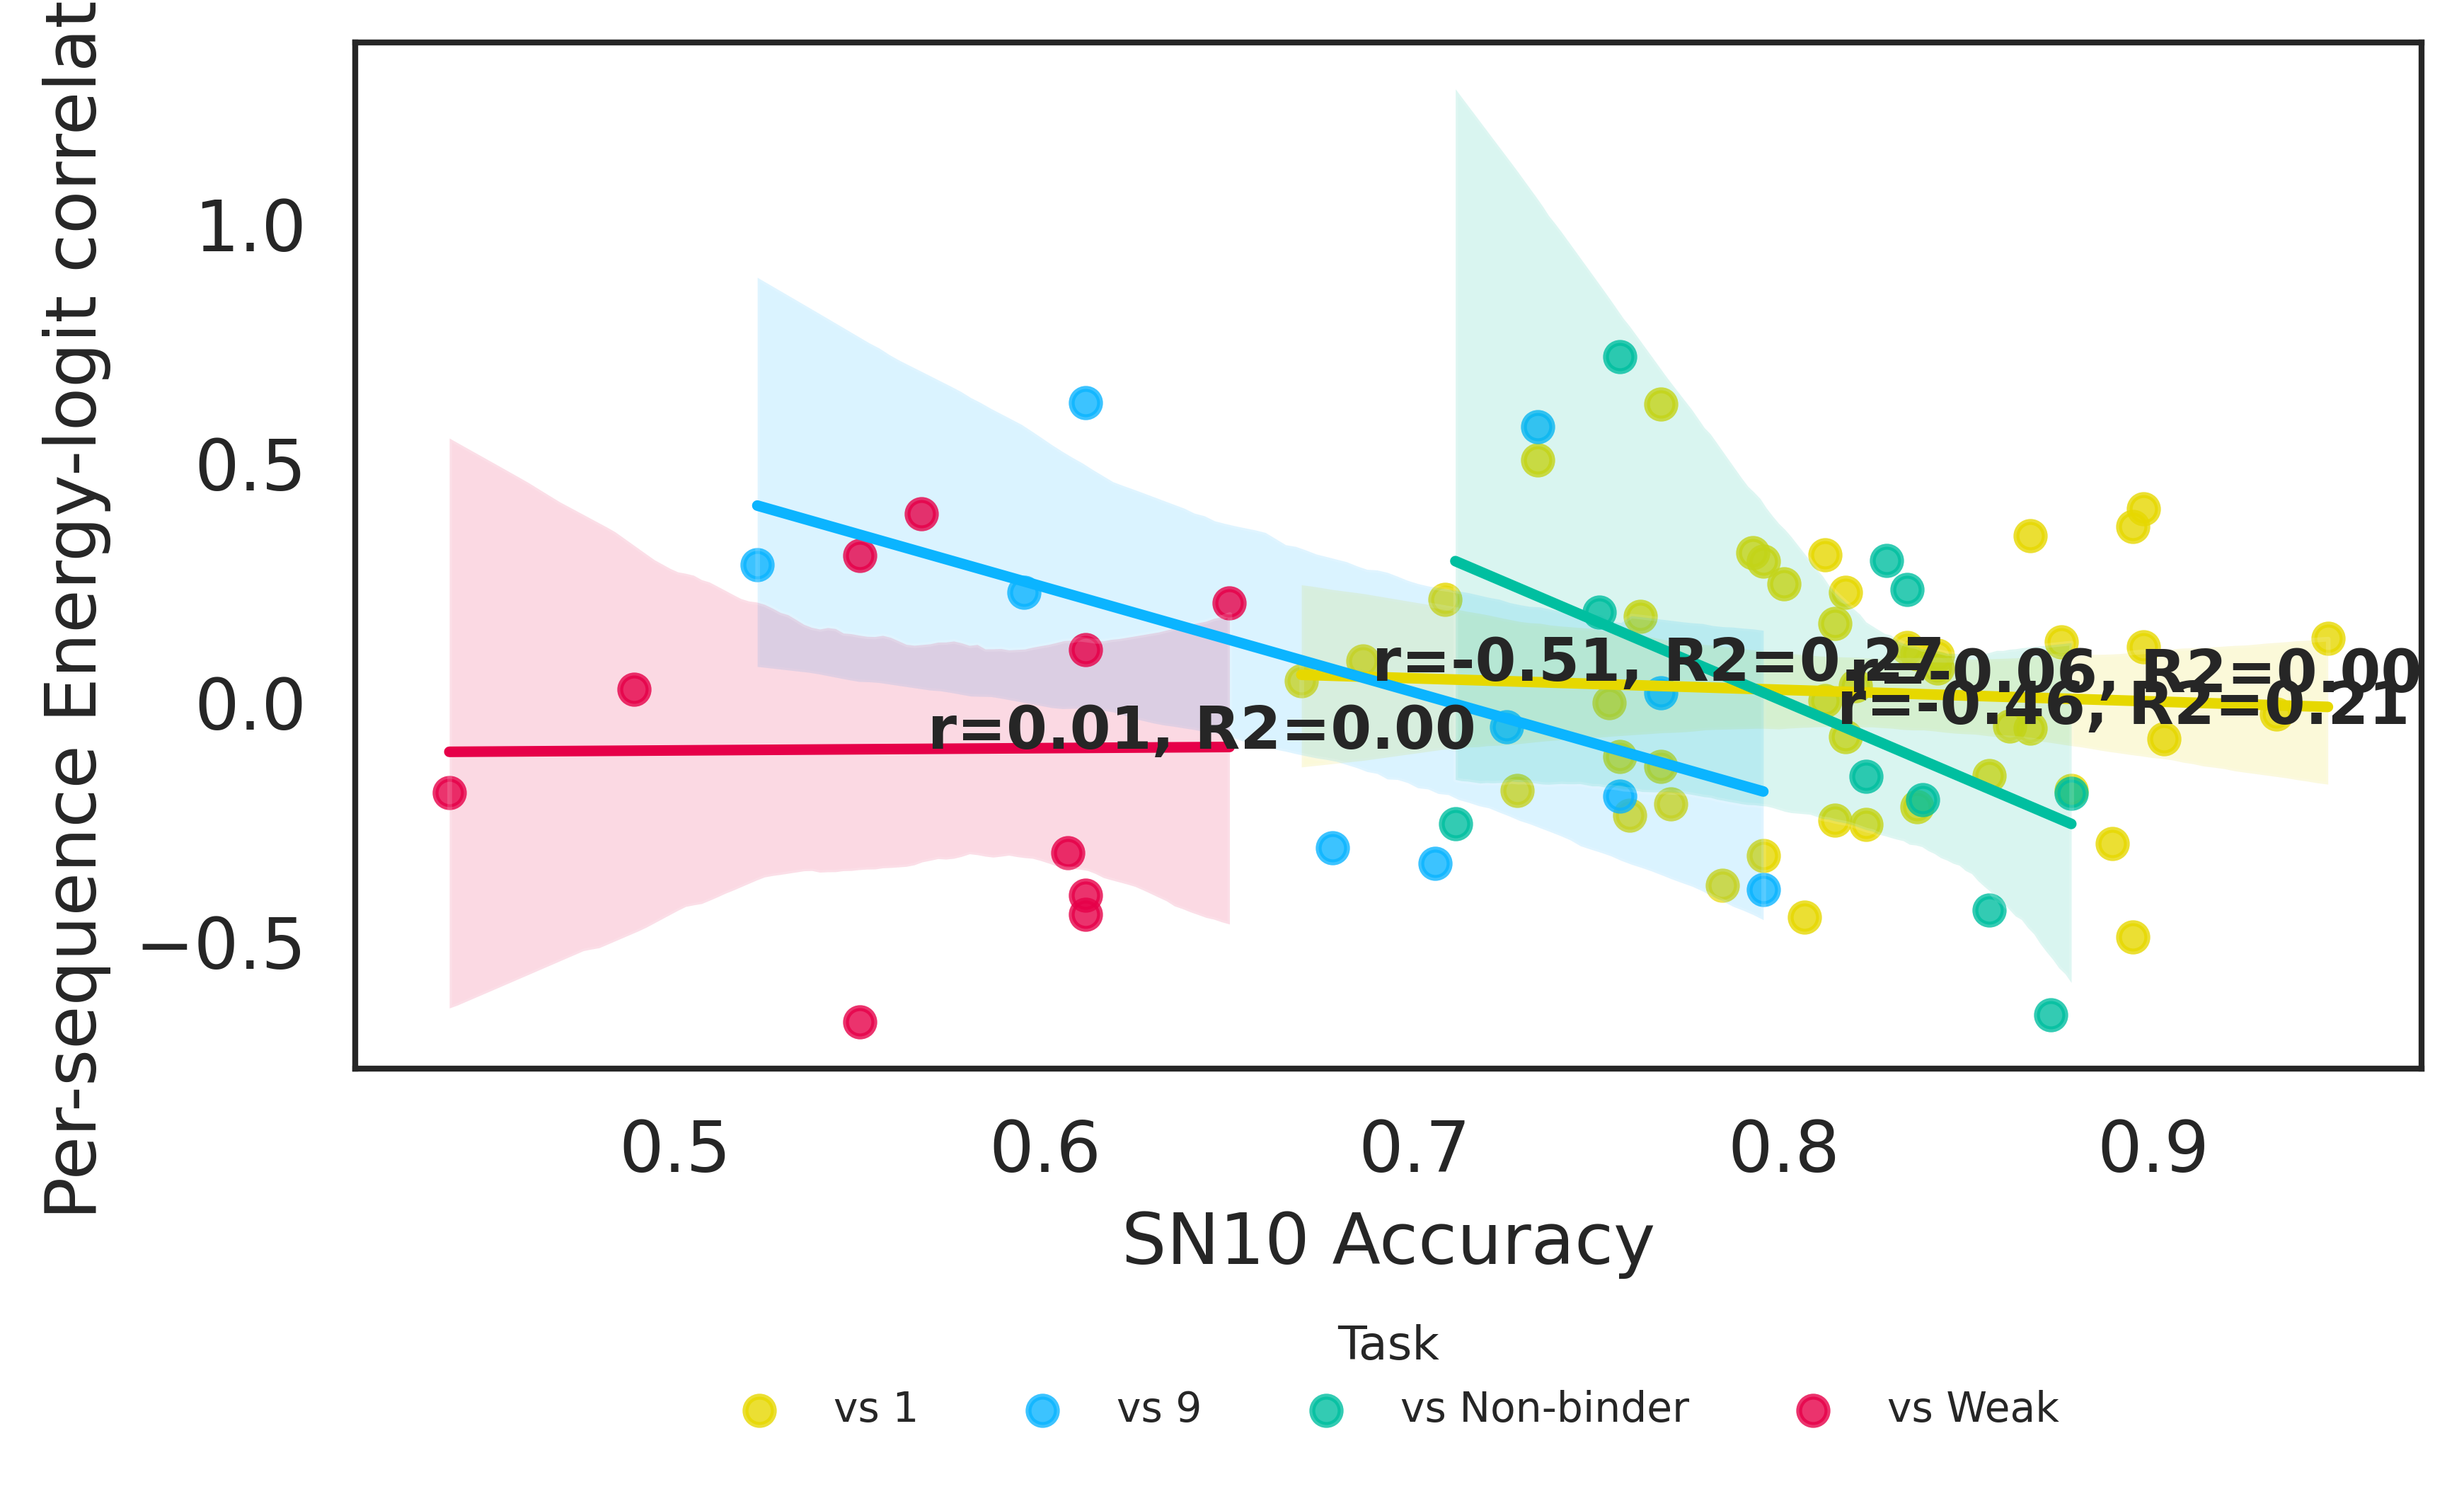

In [11]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Map to tasks clean
df_merged["task_type_clean"] = df_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# Line plot in seaborn with R2 regression
for i, df_g in df_merged.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="acc_closed",
        y="r_pos",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["r_pos"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    y = df_g["r_pos"].mean()
    x = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_ylabel("Per-sequence Energy-logit correlation", fontsize=FONT_SIZE)
ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

fig.show()

In [12]:
# Logits pos mean and logits ~ energy correlation rank relation
# Low
df_logits.groupby(["task_type", "ag_pos"])[["logits_pos_mean", "r_pos"]].mean().corr()

,logits_pos_mean,r_pos
logits_pos_mean,1.00000,-0.13292
r_pos,-0.13292,1.00000


In [13]:
## ANOVA and TWO-WAY ANOVOA
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
  
# Performing two-way ANOVA 
model = ols( 
    'r_pos ~ C(ag_pos)', data=df_logits).fit() 
sm.stats.anova_lm(model, typ=2) 
# model.summary()

,sum_sq,df,F,PR(>F)
C(ag_pos),10.381566,9.0,17.996271,4.958857e-18
Residual,7.050672,110.0,NaN,NaN


In [14]:
## ANOVA and TWO-WAY ANOVOA

# Performing two-way ANOVA 
model = ols( 
    'r_pos ~ C(task_type):C(ag_pos)', data=df_logits).fit() 
sm.stats.anova_lm(model, typ=2) 

,sum_sq,df,F,PR(>F)
C(task_type):C(ag_pos),11.459942,39.0,3.936103,1.086524e-07
Residual,5.972296,80.0,NaN,NaN


Energy contributions ~ Attributions correlations

In [15]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version
from utils_07 import get_attr_from_records, get_onehotstack_from_records

In [22]:
energy_contributions_path = "../data/Frozen_MiniAbsolut_ML/AttributionEnergyCorrelations.tsv"

force_run_contrib = True
skip_errors_contrib = True

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:

    records = []
    for task in task_generator(seed_split_ids=((0, 42), )):
        
        if skip_errors_contrib:
            try:
                stats = load_energy_contributions_from_task_nonlinear_version(task, attr_analysis_name="Test", attributor_name="DeepLIFT_LOCAL_Test")
            except:
                continue
        else:
            stats = load_energy_contributions_from_task_nonlinear_version(task, attr_analysis_name="Test", attributor_name="DeepLIFT_LOCAL_Test")
        
        records.append(stats)

    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424

In [23]:
df_attrib

,task_type,ag_pos,ag_neg,seed_id,split_id,mean,std,mean_pos,std_pos,mean_neg,...,mean_pos_fold,std_pos_fold,mean_neg_fold,std_neg_fold,mean_total,std_total,mean_pos_total,std_pos_total,mean_neg_total,std_neg_total
0,1v1,3VRL,1NSN,0,42,-0.243776,0.335747,-0.243776,0.335747,NaN,...,0.071598,0.379388,NaN,NaN,-0.234858,0.343431,-0.234858,0.343431,NaN,NaN
1,1v1,3VRL,3RAJ,0,42,-0.129069,0.321165,-0.129069,0.321165,NaN,...,0.132988,0.260955,NaN,NaN,-0.087267,0.357337,-0.087267,0.357337,NaN,NaN
2,1v1,3VRL,5E94,0,42,-0.090703,0.323612,-0.090703,0.323612,NaN,...,0.282376,0.215334,NaN,NaN,0.010878,0.354837,0.010878,0.354837,NaN,NaN
3,1v1,3VRL,1H0D,0,42,-0.241023,0.216072,-0.241023,0.216072,NaN,...,0.208098,0.322979,NaN,NaN,-0.162466,0.294930,-0.162466,0.294930,NaN,NaN
4,1v1,3VRL,1WEJ,0,42,-0.266972,0.379667,-0.266972,0.379667,NaN,...,0.093567,0.236061,NaN,NaN,-0.225334,0.364265,-0.225334,0.364265,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,high_vs_95low,2YPV,auto,0,42,-0.371802,0.355887,-0.564174,0.240946,-0.179429,...,0.021504,NaN,-0.272413,0.284960,-0.399065,0.325719,-0.565663,0.238198,-0.232467,0.325976
116,high_vs_looser,2YPV,auto,0,42,-0.048472,0.300881,0.054810,0.347673,-0.151754,...,-0.055529,NaN,-0.131072,0.556544,-0.056579,0.296654,0.058745,0.352661,-0.171903,0.180871
117,1v9,1OB1,auto,0,42,-0.001044,0.420812,-0.001044,0.420812,NaN,...,-0.074611,0.112783,NaN,NaN,-0.020593,0.432518,-0.020593,0.432518,NaN,NaN
118,high_vs_95low,1OB1,auto,0,42,-0.405893,0.220151,-0.522098,0.127534,-0.289688,...,-0.018475,0.301250,0.023773,0.324122,-0.419432,0.213893,-0.542481,0.121259,-0.296384,0.220111


/tmp/ipykernel_317905/2236275920.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')

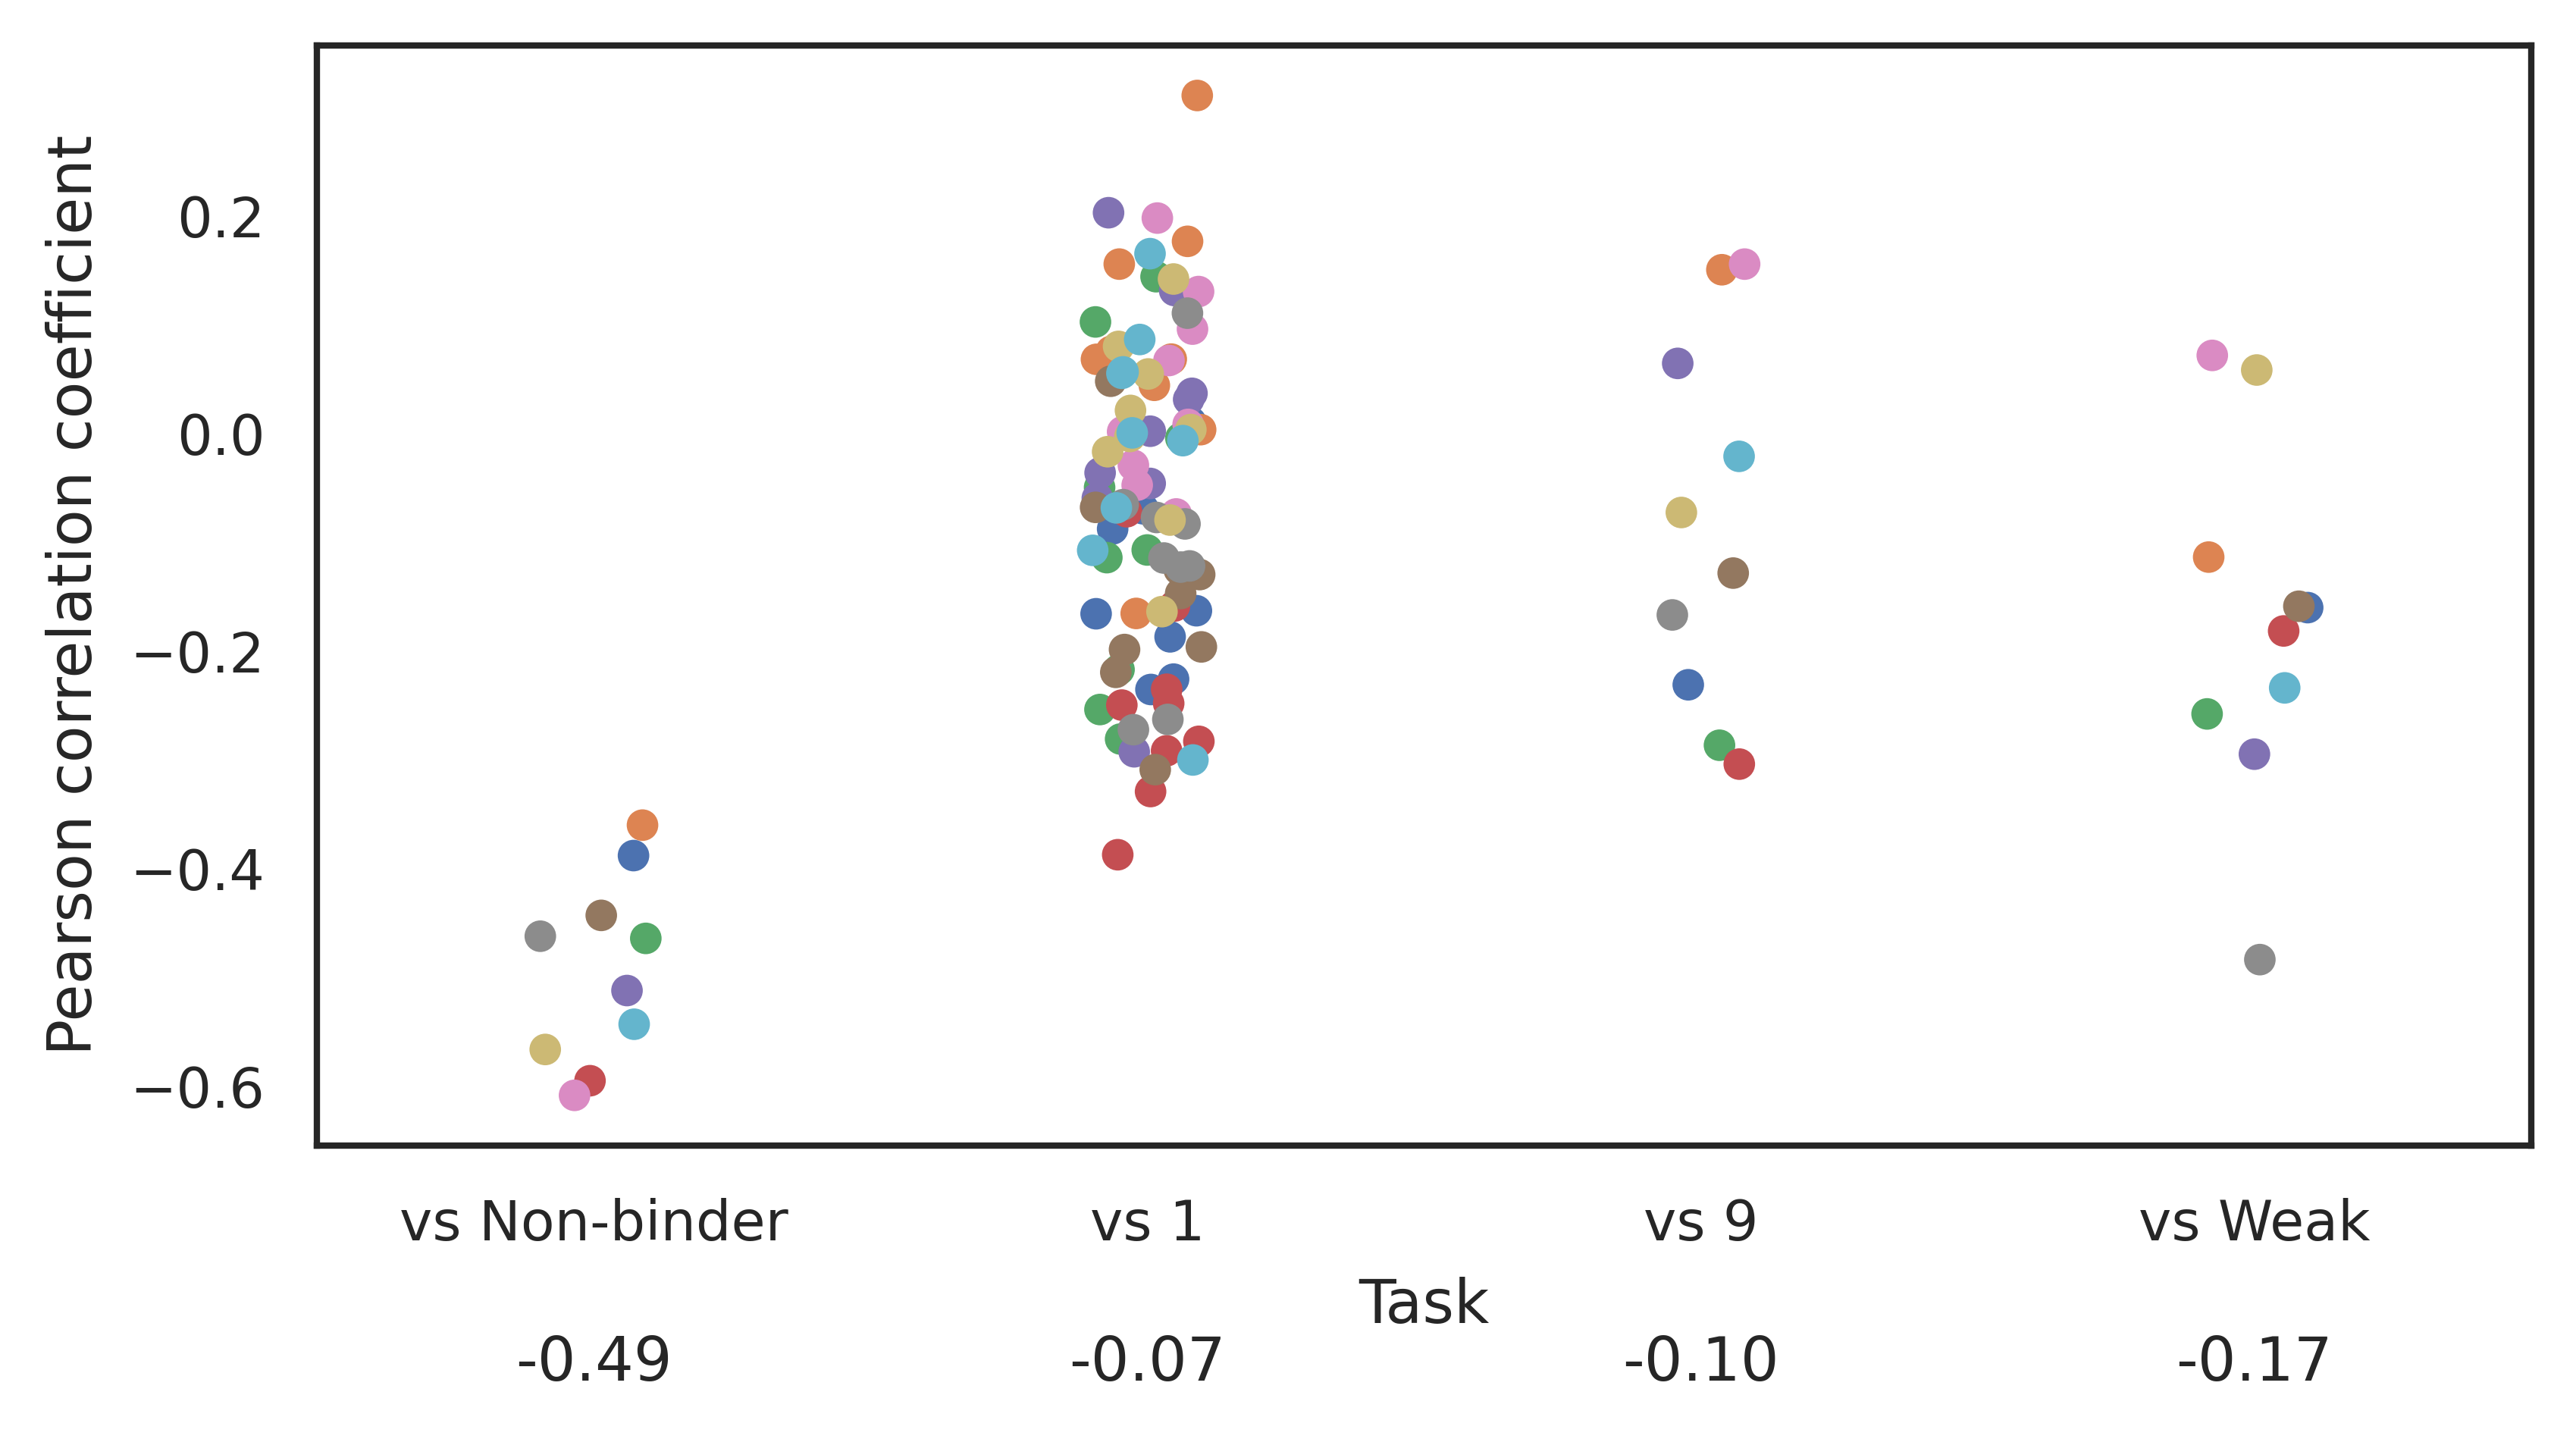

In [26]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    # cmap=visualisations.PlotParams.cmap_antigens,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

In [27]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_attrib.query("task_type == 'high_vs_95low'")["mean_pos_total"],
    df_attrib.query("task_type == '1v1'")["mean_pos_total"],
    df_attrib.query("task_type == '1v9'")["mean_pos_total"],
    df_attrib.query("task_type == 'high_vs_looser'")["mean_pos_total"],
)

F_onewayResult(statistic=27.362973659858287, pvalue=1.8683453222216475e-13)

In [28]:
define_task_col(df_attrib)
df_attrib_agg = df_attrib.groupby(["task", "task_type"]).agg({"mean_pos_total": "mean"}).reset_index()
df_contributions_merged = pd.merge(df_acc_agg, df_attrib_agg, on=["task", "task_type"], how='inner')
df_contributions_merged

,task,task_type,acc_closed,mean_pos_total
0,1v1_1ADQ_1FBI,1v1,0.866667,-0.084195
1,1v1_1ADQ_1H0D,1v1,0.811111,-0.059516
2,1v1_1ADQ_1NSN,1v1,0.766667,0.042327
3,1v1_1ADQ_1OB1,1v1,0.813889,-0.000236
4,1v1_1ADQ_1WEJ,1v1,0.800000,-0.098037
...,...,...,...,...
70,high_vs_looser_1WEJ_1WEJ,high_vs_looser,0.650000,-0.158351
71,high_vs_looser_2YPV_2YPV,high_vs_looser,0.611111,0.058745
72,high_vs_looser_3RAJ_3RAJ,high_vs_looser,0.438889,-0.257305
73,high_vs_looser_3VRL_3VRL,high_vs_looser,0.606250,-0.159608


vs 1
vs 9
vs Non-binder
vs Weak


/tmp/ipykernel_317905/2910997607.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


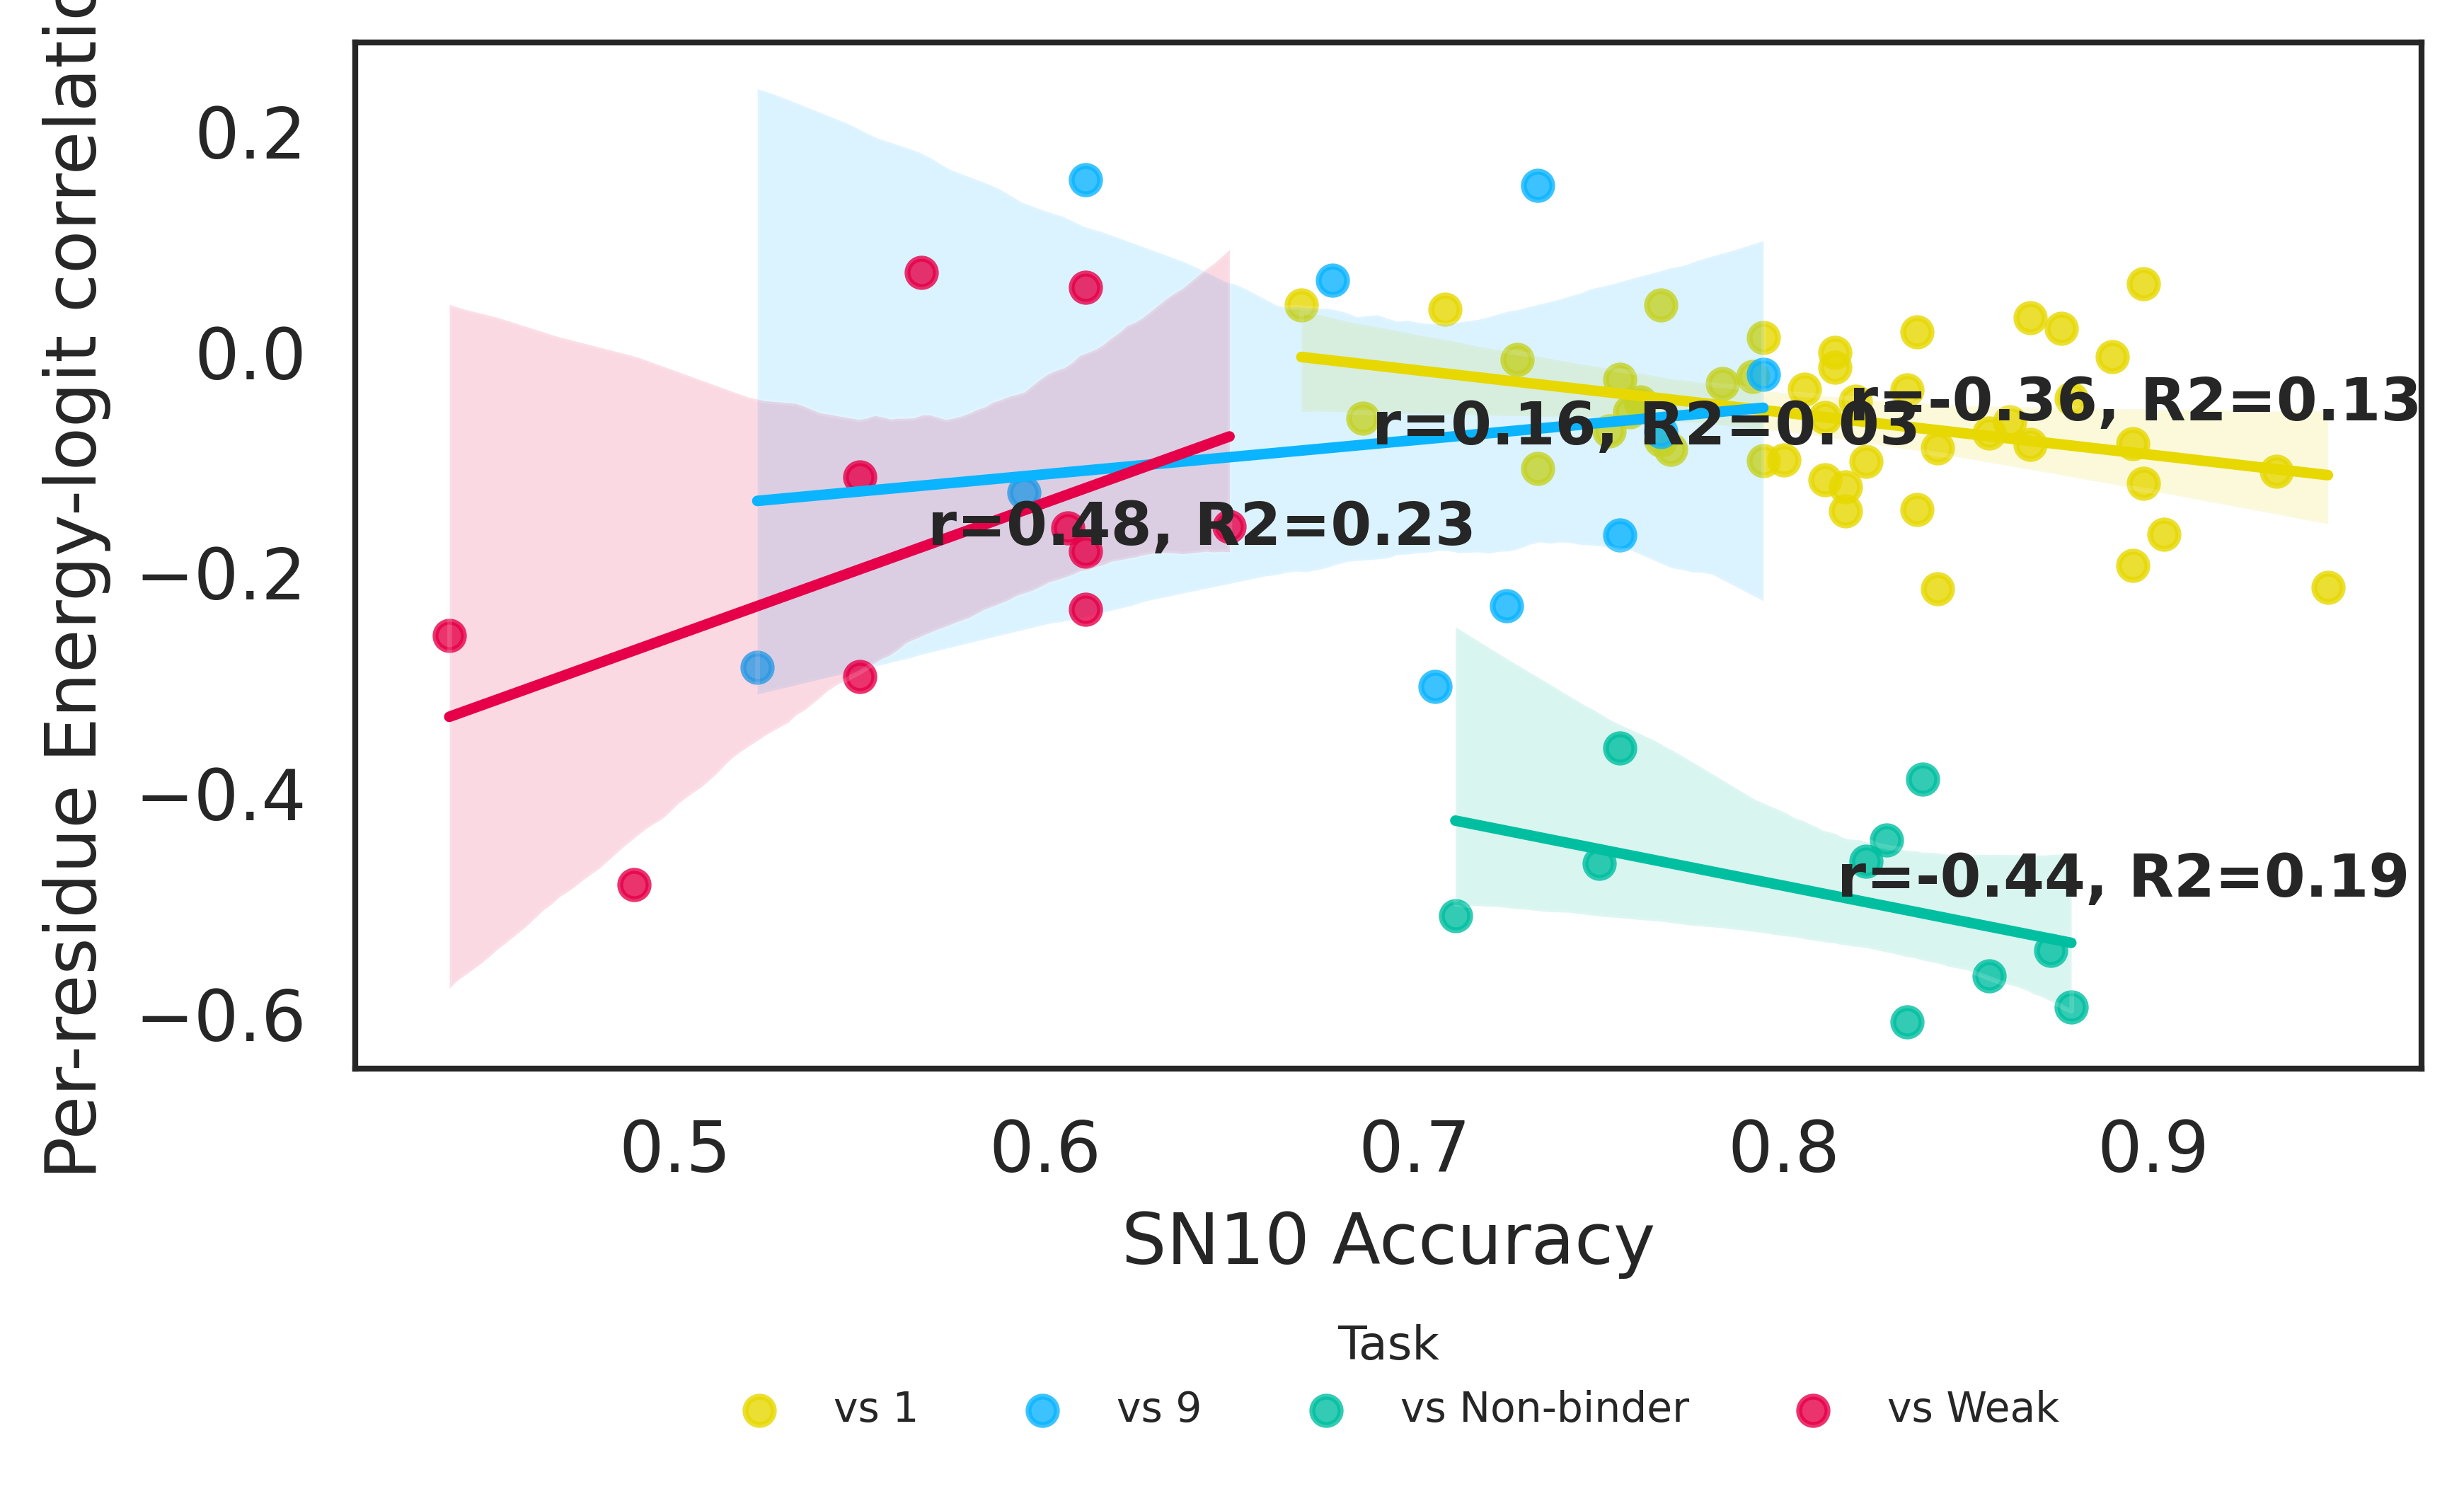

In [30]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Map to tasks clean
df_contributions_merged["task_type_clean"] = df_contributions_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# Line plot in seaborn with R2 regression
for i, df_g in df_contributions_merged.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="acc_closed",
        y="mean_pos_total",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["mean_pos_total"], df_g["acc_closed"])
    # Add text with r and R2 at centroid
    y = df_g["mean_pos_total"].mean()
    x = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_ylabel("Per-residue Energy-logit correlation", fontsize=FONT_SIZE)
ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

fig.show()

1v1 results, logits

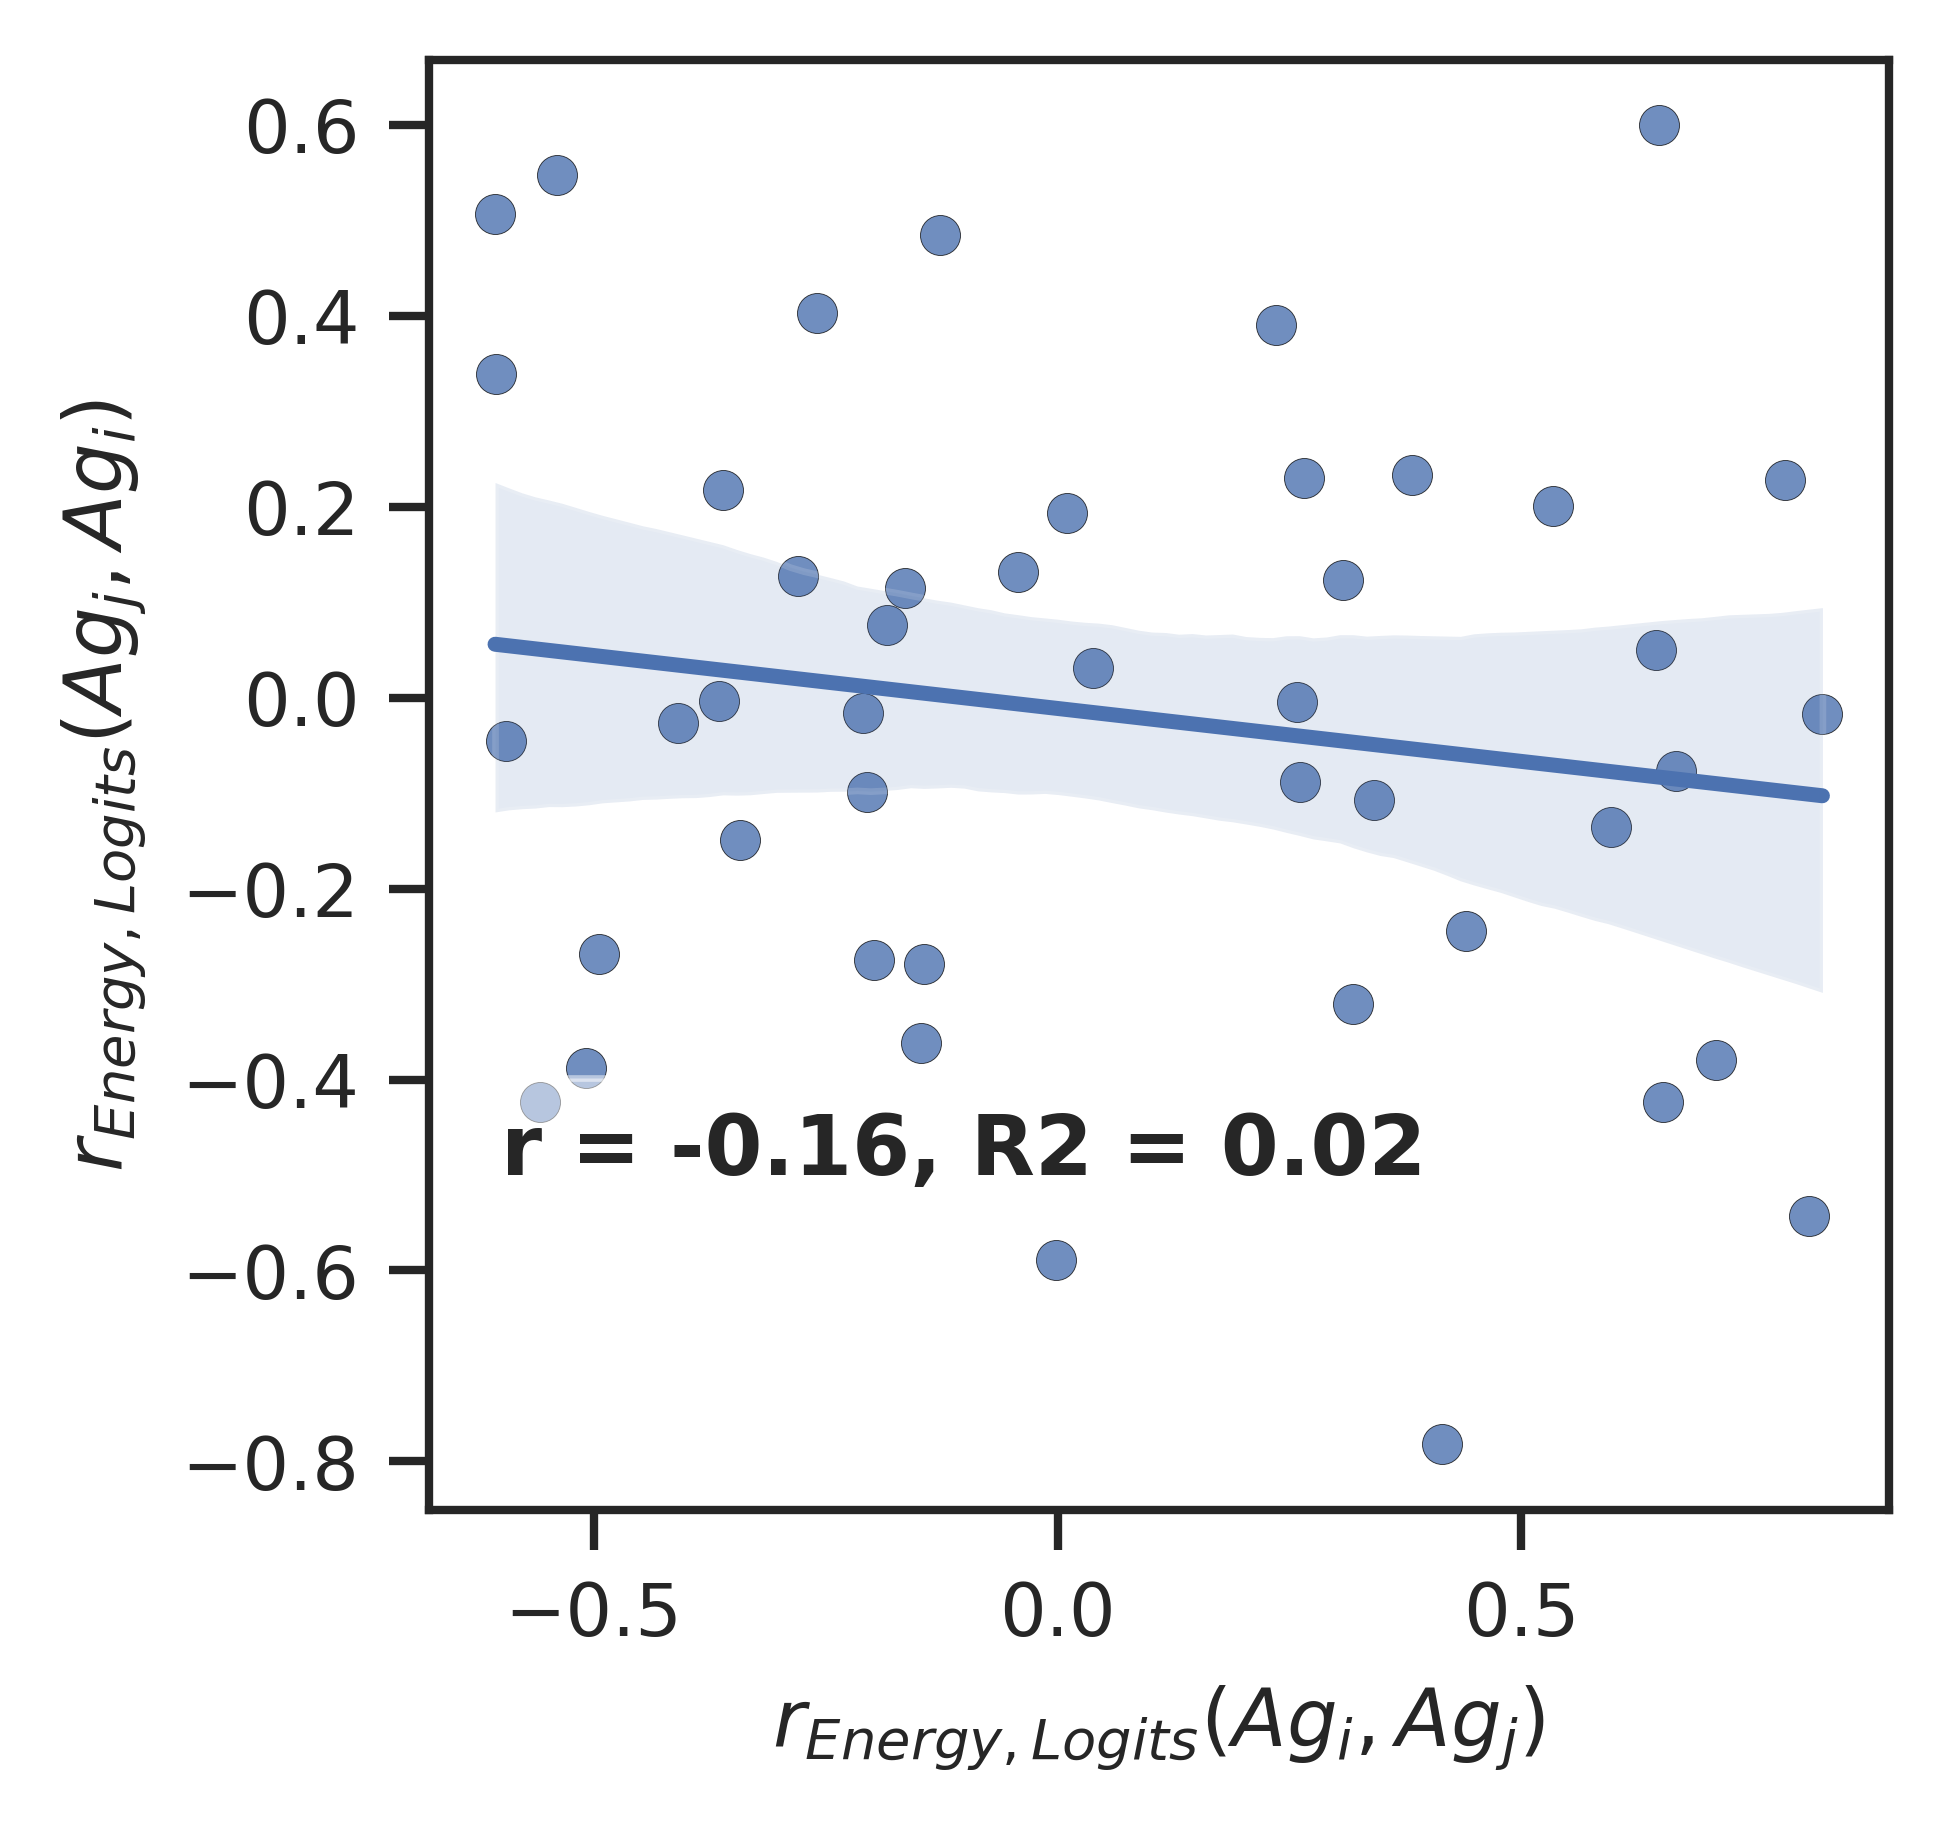

In [31]:
# Add results of 1v1 adapted
from itertools import combinations

df_logits_1v1 = df_logits.query("task_type == '1v1'").copy()
ags = df_logits_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_logits_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").r_pos.median()
    r_bwd = df_logits_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").r_pos.median()
    res.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
    })


df_logits_1v1_sum = pd.DataFrame.from_records(res)

plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)

sns.regplot(
    data=df_logits_1v1_sum,
    x="r_fwd",
    y="r_bwd",
    scatter_kws={'edgecolor': 'black', 'linewidth': 0.1},
    ax=ax,
)

# Add text with correlation coefficient, R2
# Location: bottom, left
r, p = pearsonr(df_logits_1v1_sum["r_fwd"], df_logits_1v1_sum["r_bwd"])
ax.text(
    -0.6,
    -0.5,
    f"r = {r:.2f}, R2 = {r**2:.2f}",
    fontsize=10,
    fontweight="bold",
    bbox=dict(facecolor="white", alpha=0.5),
)

ax.set_xlabel("$r_{Energy,Logits}(Ag_i, Ag_j)$")
ax.set_ylabel("$r_{Energy,Logits}(Ag_j, Ag_i)$")
fig.savefig("figures/Supp_Figure_6_A.svg")

In [32]:
## Reduce the 1v1 to a single value by min of abs value!

df_logits_1v1 = df_logits.query("task_type == '1v1'").copy()
ags = df_logits_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_logits_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").r_pos.median()
    r_bwd = df_logits_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").r_pos.median()
    res.append({
        "ag_pos": ag_1,
        "ag_neg": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
        # Adapted
        "task_type": "1v1_adapted",
        "r_pos": -max([abs(r_fwd), abs(r_bwd)]),
    })

df_logits_1v1_adapted = pd.DataFrame.from_records(res)
df_logits = pd.concat([df_logits, df_logits_1v1_adapted], axis=0)

In [33]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
1v1            -0.781997 -0.010498  0.824404
1v1_adapted    -0.824404 -0.402990 -0.037816
1v9            -0.390399 -0.015804  0.625707
high_vs_95low  -0.653176 -0.172293  0.721793
high_vs_looser -0.668152 -0.080362  0.393446

/tmp/ipykernel_317905/3581558910.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


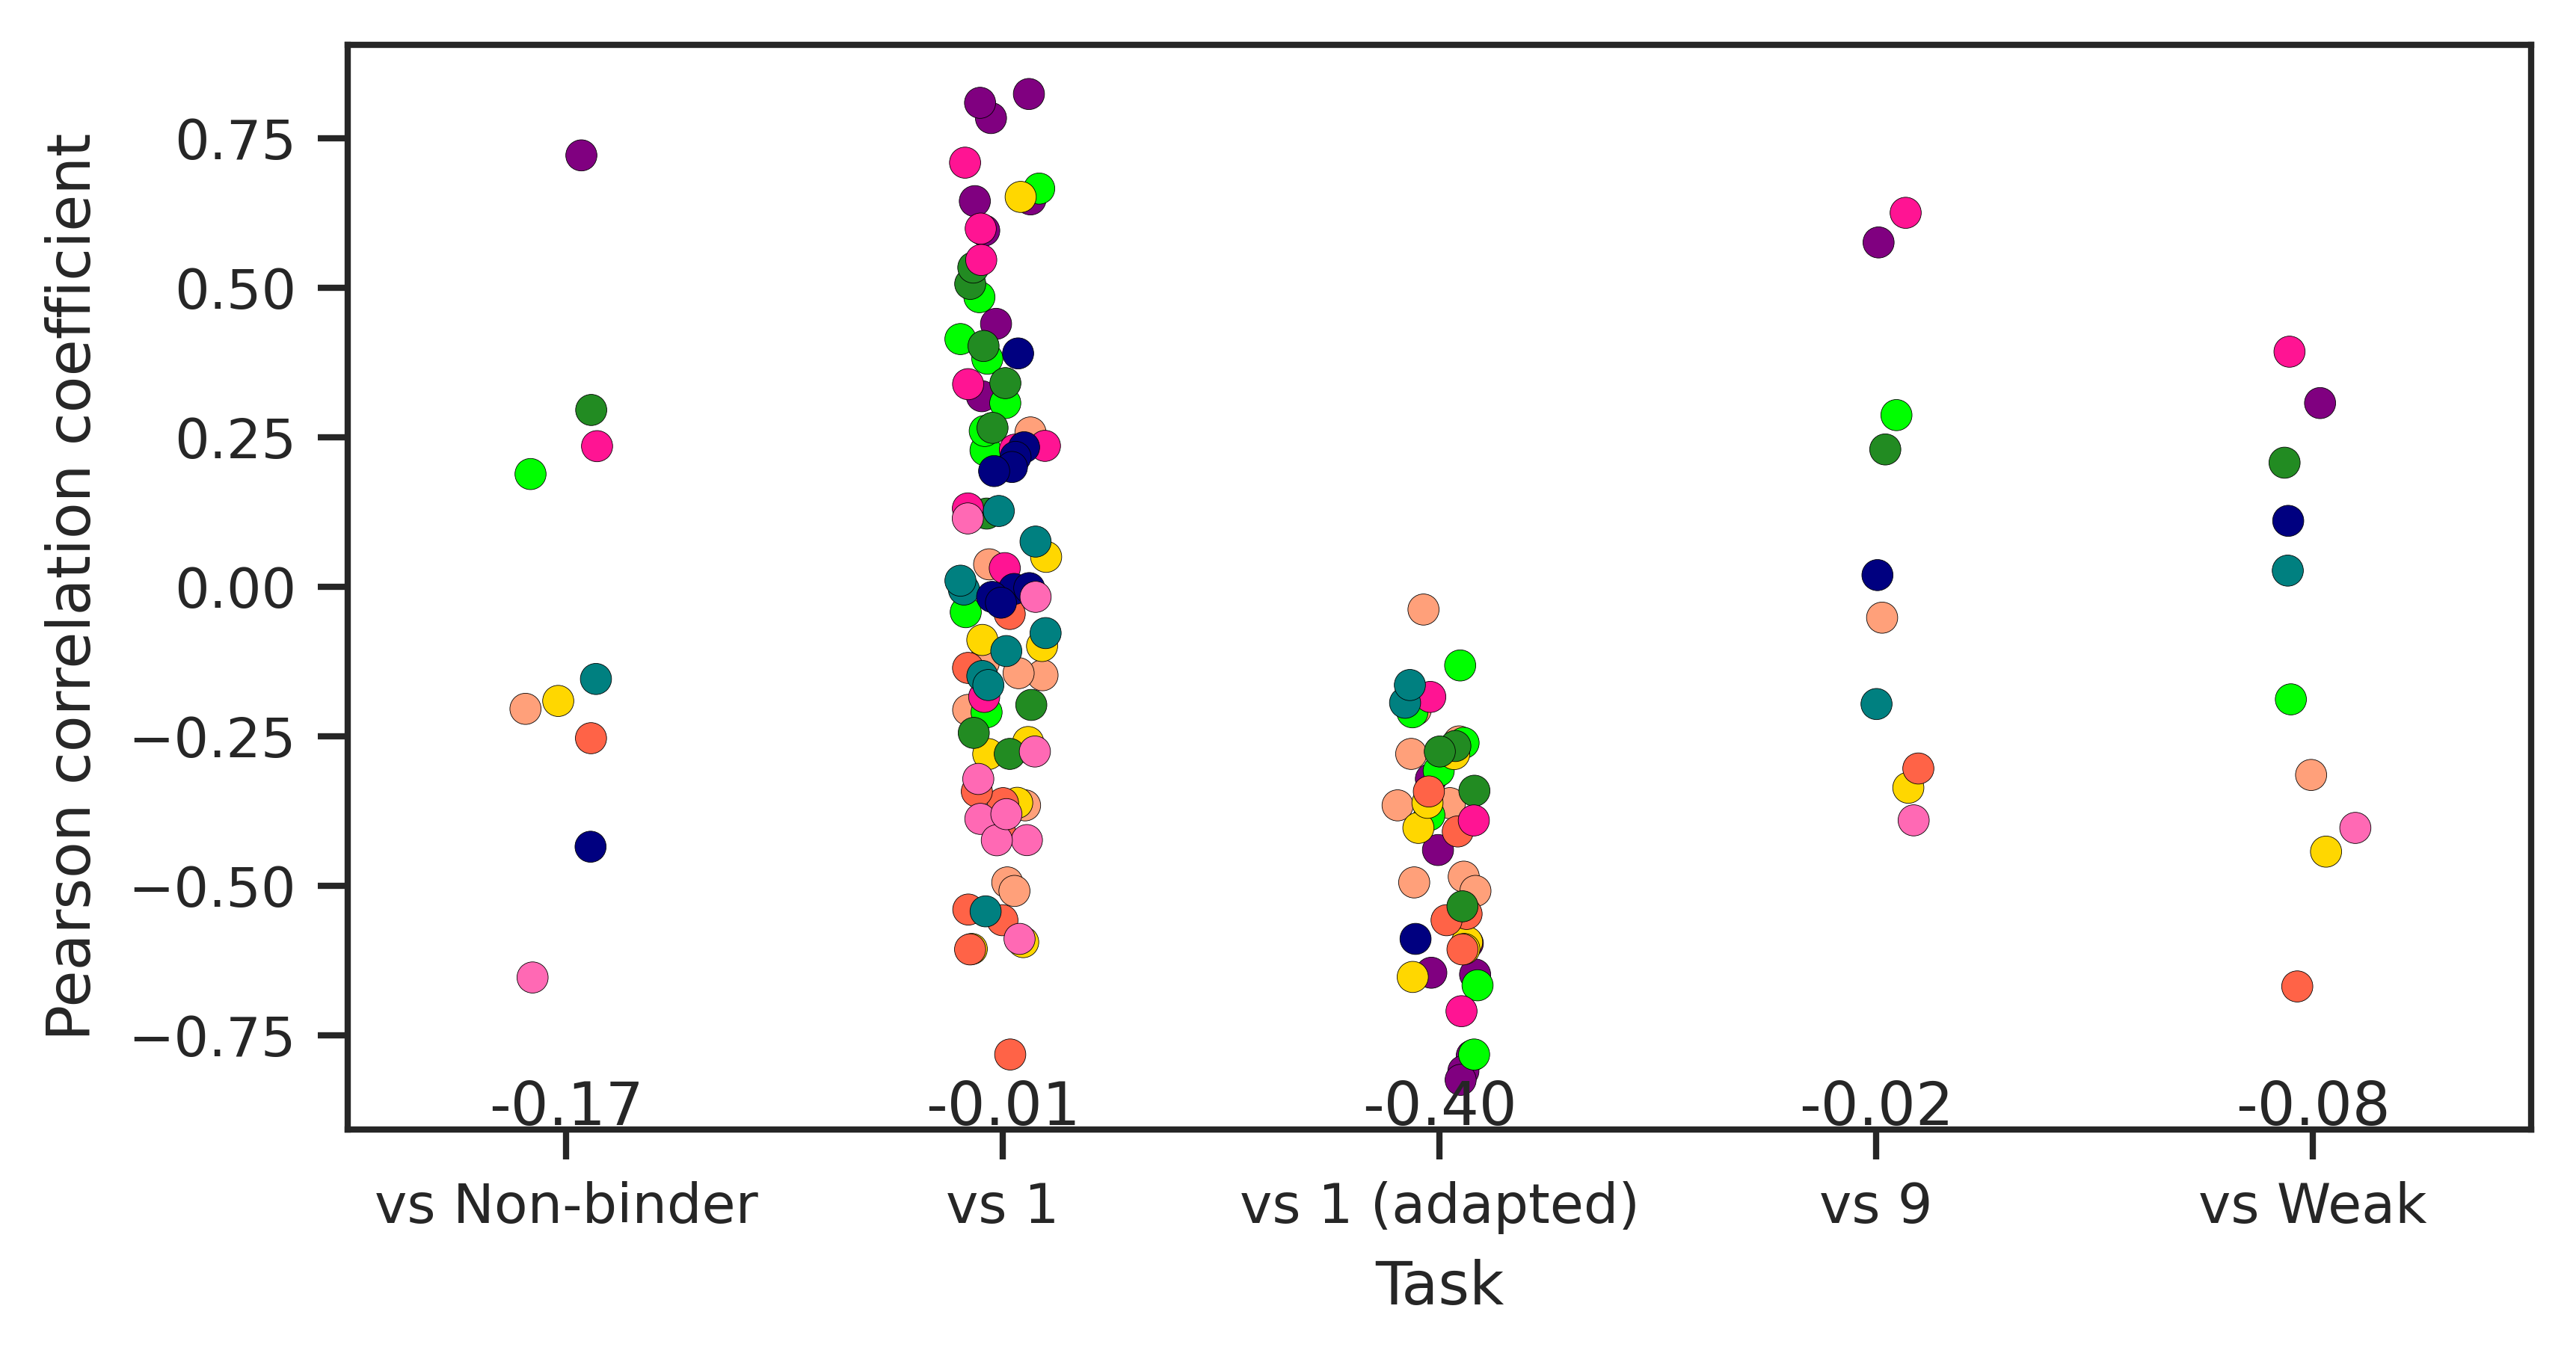

In [34]:
plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

palette = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'}

task_order = ["high_vs_95low", "1v1", "1v1_adapted", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos",
    hue="ag_pos", 
    ax=ax, 
    # cmap=visualisations.PlotParams.cmap_antigens,
    palette=palette,
    order=task_order,
    edgecolor = 'black',
    linewidth =  0.1,
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.9,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

# Save fig as .svg
fig.savefig("figures/Supp_Figure_6_B.svg")

1v1 attributions

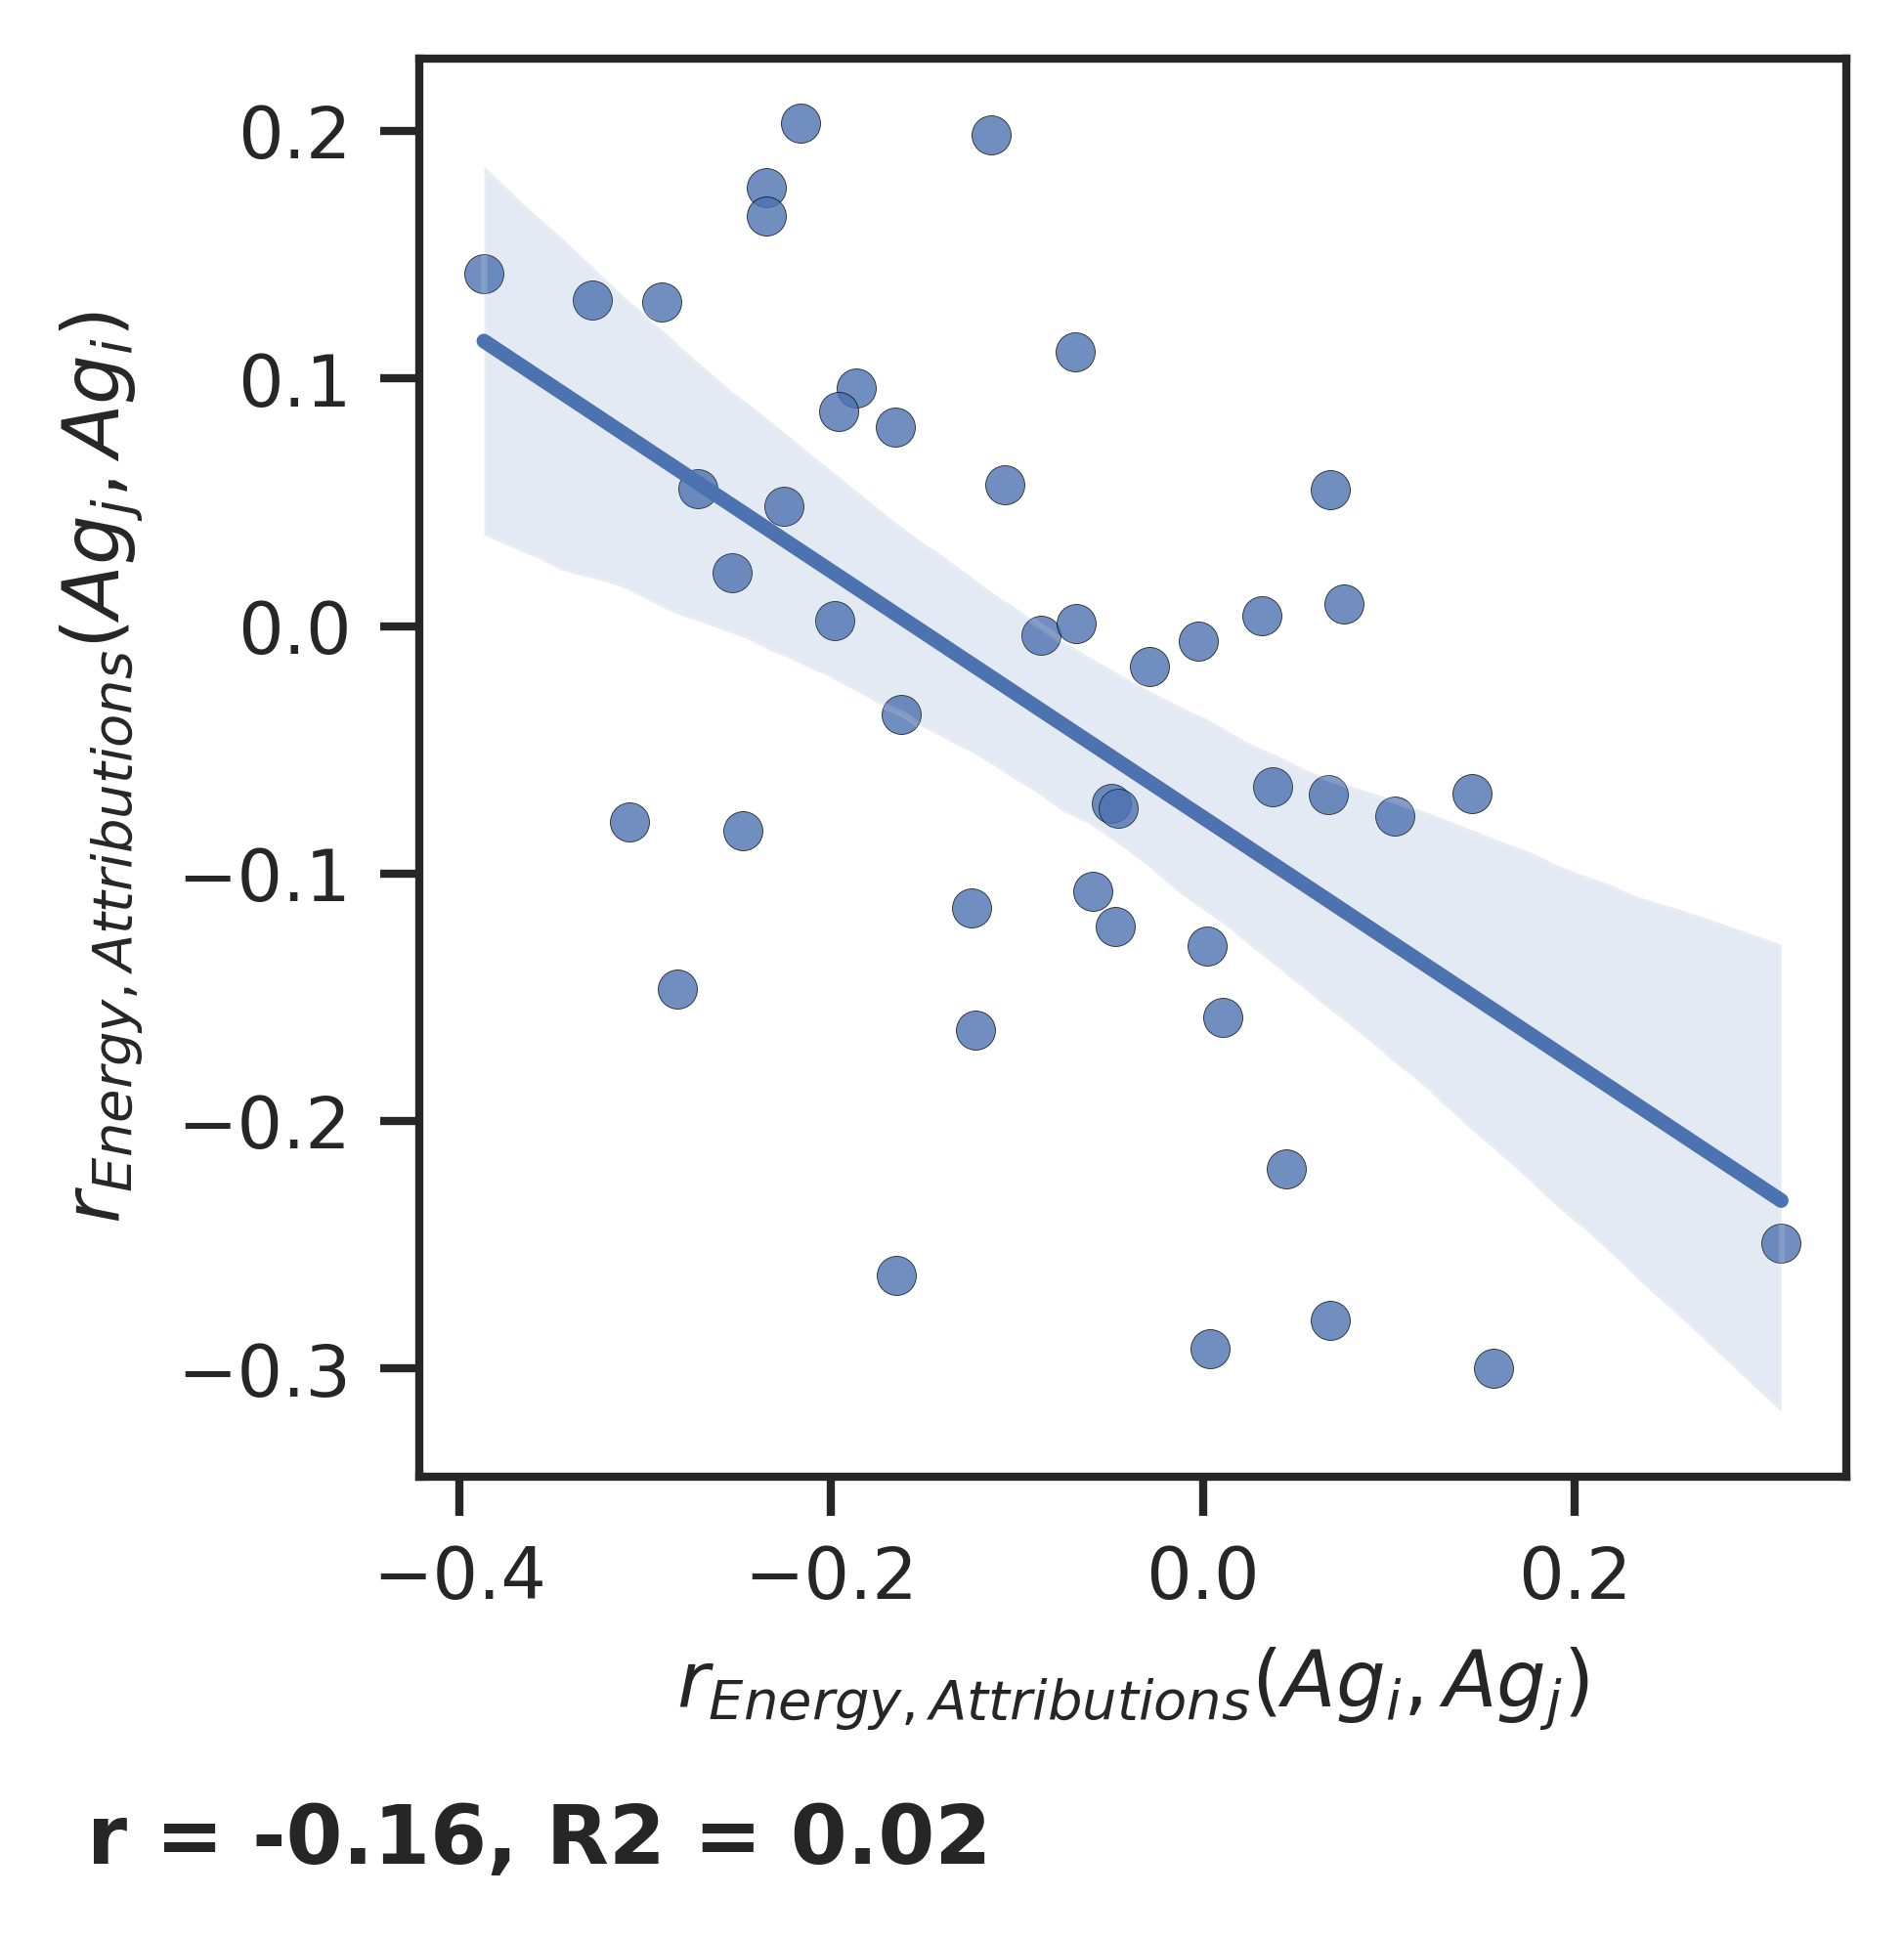

In [35]:
## There is a pattern for 1v1 when one looks at the correlation between forward and backwards, there is antisymmetry!

from itertools import combinations

df_attrib_1v1 = df_attrib.query("task_type == '1v1'").copy()
ags = df_attrib_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_attrib_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").mean_pos_total.median()
    r_bwd = df_attrib_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").mean_pos_total.median()
    res.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
    })


df_attrib_1v1_sum = pd.DataFrame.from_records(res)

plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)

sns.regplot(
    data=df_attrib_1v1_sum,
    x="r_fwd",
    y="r_bwd",
    scatter_kws={'edgecolor': 'black', 'linewidth': 0.1},
    ax=ax,
)

# Add text with correlation coefficient, R2
# Location: bottom, left
r, p = pearsonr(df_logits_1v1_sum["r_fwd"], df_logits_1v1_sum["r_bwd"])
ax.text(
    -0.6,
    -0.5,
    f"r = {r:.2f}, R2 = {r**2:.2f}",
    fontsize=10,
    fontweight="bold",
    bbox=dict(facecolor="white", alpha=0.5),
)

ax.set_xlabel("$r_{Energy,Attributions}(Ag_i, Ag_j)$")
ax.set_ylabel("$r_{Energy,Attributions}(Ag_j, Ag_i)$")
fig.savefig("figures/Supp_Figure_6_C.svg")

In [36]:
df_attrib_1v1.sort_values("mean_pos_total")

,task_type,ag_pos,ag_neg,seed_id,split_id,mean,std,mean_pos,std_pos,mean_neg,...,std_pos_fold,mean_neg_fold,std_neg_fold,mean_total,std_total,mean_pos_total,std_pos_total,mean_neg_total,std_neg_total,task
34,1v1,5E94,2YPV,0,42,-0.412398,0.208819,-0.412398,0.208819,NaN,...,0.294777,NaN,NaN,-0.386706,0.231457,-0.386706,0.231457,NaN,NaN,1v1_2YPV_5E94
30,1v1,5E94,1H0D,0,42,-0.326093,0.249371,-0.326093,0.249371,NaN,...,0.242963,NaN,NaN,-0.328626,0.244874,-0.328626,0.244874,NaN,NaN,1v1_1H0D_5E94
52,1v1,1WEJ,2YPV,0,42,-0.298347,0.113594,-0.298347,0.113594,NaN,...,0.276406,NaN,NaN,-0.308511,0.108716,-0.308511,0.108716,NaN,NaN,1v1_1WEJ_2YPV
82,1v1,1OB1,1NSN,0,42,-0.284051,0.281939,-0.284051,0.281939,NaN,...,0.377551,NaN,NaN,-0.299626,0.284333,-0.299626,0.284333,NaN,NaN,1v1_1NSN_1OB1
37,1v1,1H0D,1NSN,0,42,-0.343964,0.299232,-0.343964,0.299232,NaN,...,0.182144,NaN,NaN,-0.292098,0.276409,-0.292098,0.276409,NaN,NaN,1v1_1H0D_1NSN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1v1,1OB1,5E94,0,42,0.162802,0.204426,0.162802,0.204426,NaN,...,0.371022,NaN,NaN,0.165672,0.219196,0.165672,0.219196,NaN,NaN,1v1_1OB1_5E94
9,1v1,1NSN,3VRL,0,42,0.174342,0.304444,0.174342,0.304444,NaN,...,NaN,NaN,NaN,0.177006,0.299419,0.177006,0.299419,NaN,NaN,1v1_1NSN_3VRL
56,1v1,1ADQ,3RAJ,0,42,0.166478,0.259868,0.166478,0.259868,NaN,...,0.257752,NaN,NaN,0.198387,0.264353,0.198387,0.264353,NaN,NaN,1v1_1ADQ_3RAJ
38,1v1,1H0D,3RAJ,0,42,0.261679,0.282523,0.261679,0.282523,NaN,...,0.258356,NaN,NaN,0.203295,0.250060,0.203295,0.250060,NaN,NaN,1v1_1H0D_3RAJ


In [37]:
df_attrib_1v1.query("ag_pos == '5E94' and ag_neg == '2YPV'")

,task_type,ag_pos,ag_neg,seed_id,split_id,mean,std,mean_pos,std_pos,mean_neg,...,std_pos_fold,mean_neg_fold,std_neg_fold,mean_total,std_total,mean_pos_total,std_pos_total,mean_neg_total,std_neg_total,task
34,1v1,5E94,2YPV,0,42,-0.412398,0.208819,-0.412398,0.208819,NaN,...,0.294777,NaN,NaN,-0.386706,0.231457,-0.386706,0.231457,NaN,NaN,1v1_2YPV_5E94


In [38]:
df_attrib_1v1.query("ag_pos == '2YPV' and ag_neg == '5E94'")

,task_type,ag_pos,ag_neg,seed_id,split_id,mean,std,mean_pos,std_pos,mean_neg,...,std_pos_fold,mean_neg_fold,std_neg_fold,mean_total,std_total,mean_pos_total,std_pos_total,mean_neg_total,std_neg_total,task
75,1v1,2YPV,5E94,0,42,0.147352,0.315397,0.147352,0.315397,NaN,...,NaN,NaN,NaN,0.142371,0.305908,0.142371,0.305908,NaN,NaN,1v1_2YPV_5E94


In [39]:
## Reduce the 1v1 to a single value by min of abs value!

df_attrib_1v1 = df_attrib.query("task_type == '1v1'").copy()
ags = df_attrib_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_attrib_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").mean_pos_total.median()
    r_bwd = df_attrib_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").mean_pos_total.median()
    res.append({
        "ag_pos": ag_1,
        "ag_neg": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
        # Adapted
        "task_type": "1v1_adapted",
        "mean_pos_total": -min([abs(r_fwd), abs(r_bwd)]),
    })

df_attrib_1v1_adapted = pd.DataFrame.from_records(res)
df_attrib = pd.concat([df_attrib, df_attrib_1v1_adapted], axis=0)

/tmp/ipykernel_317905/268963969.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


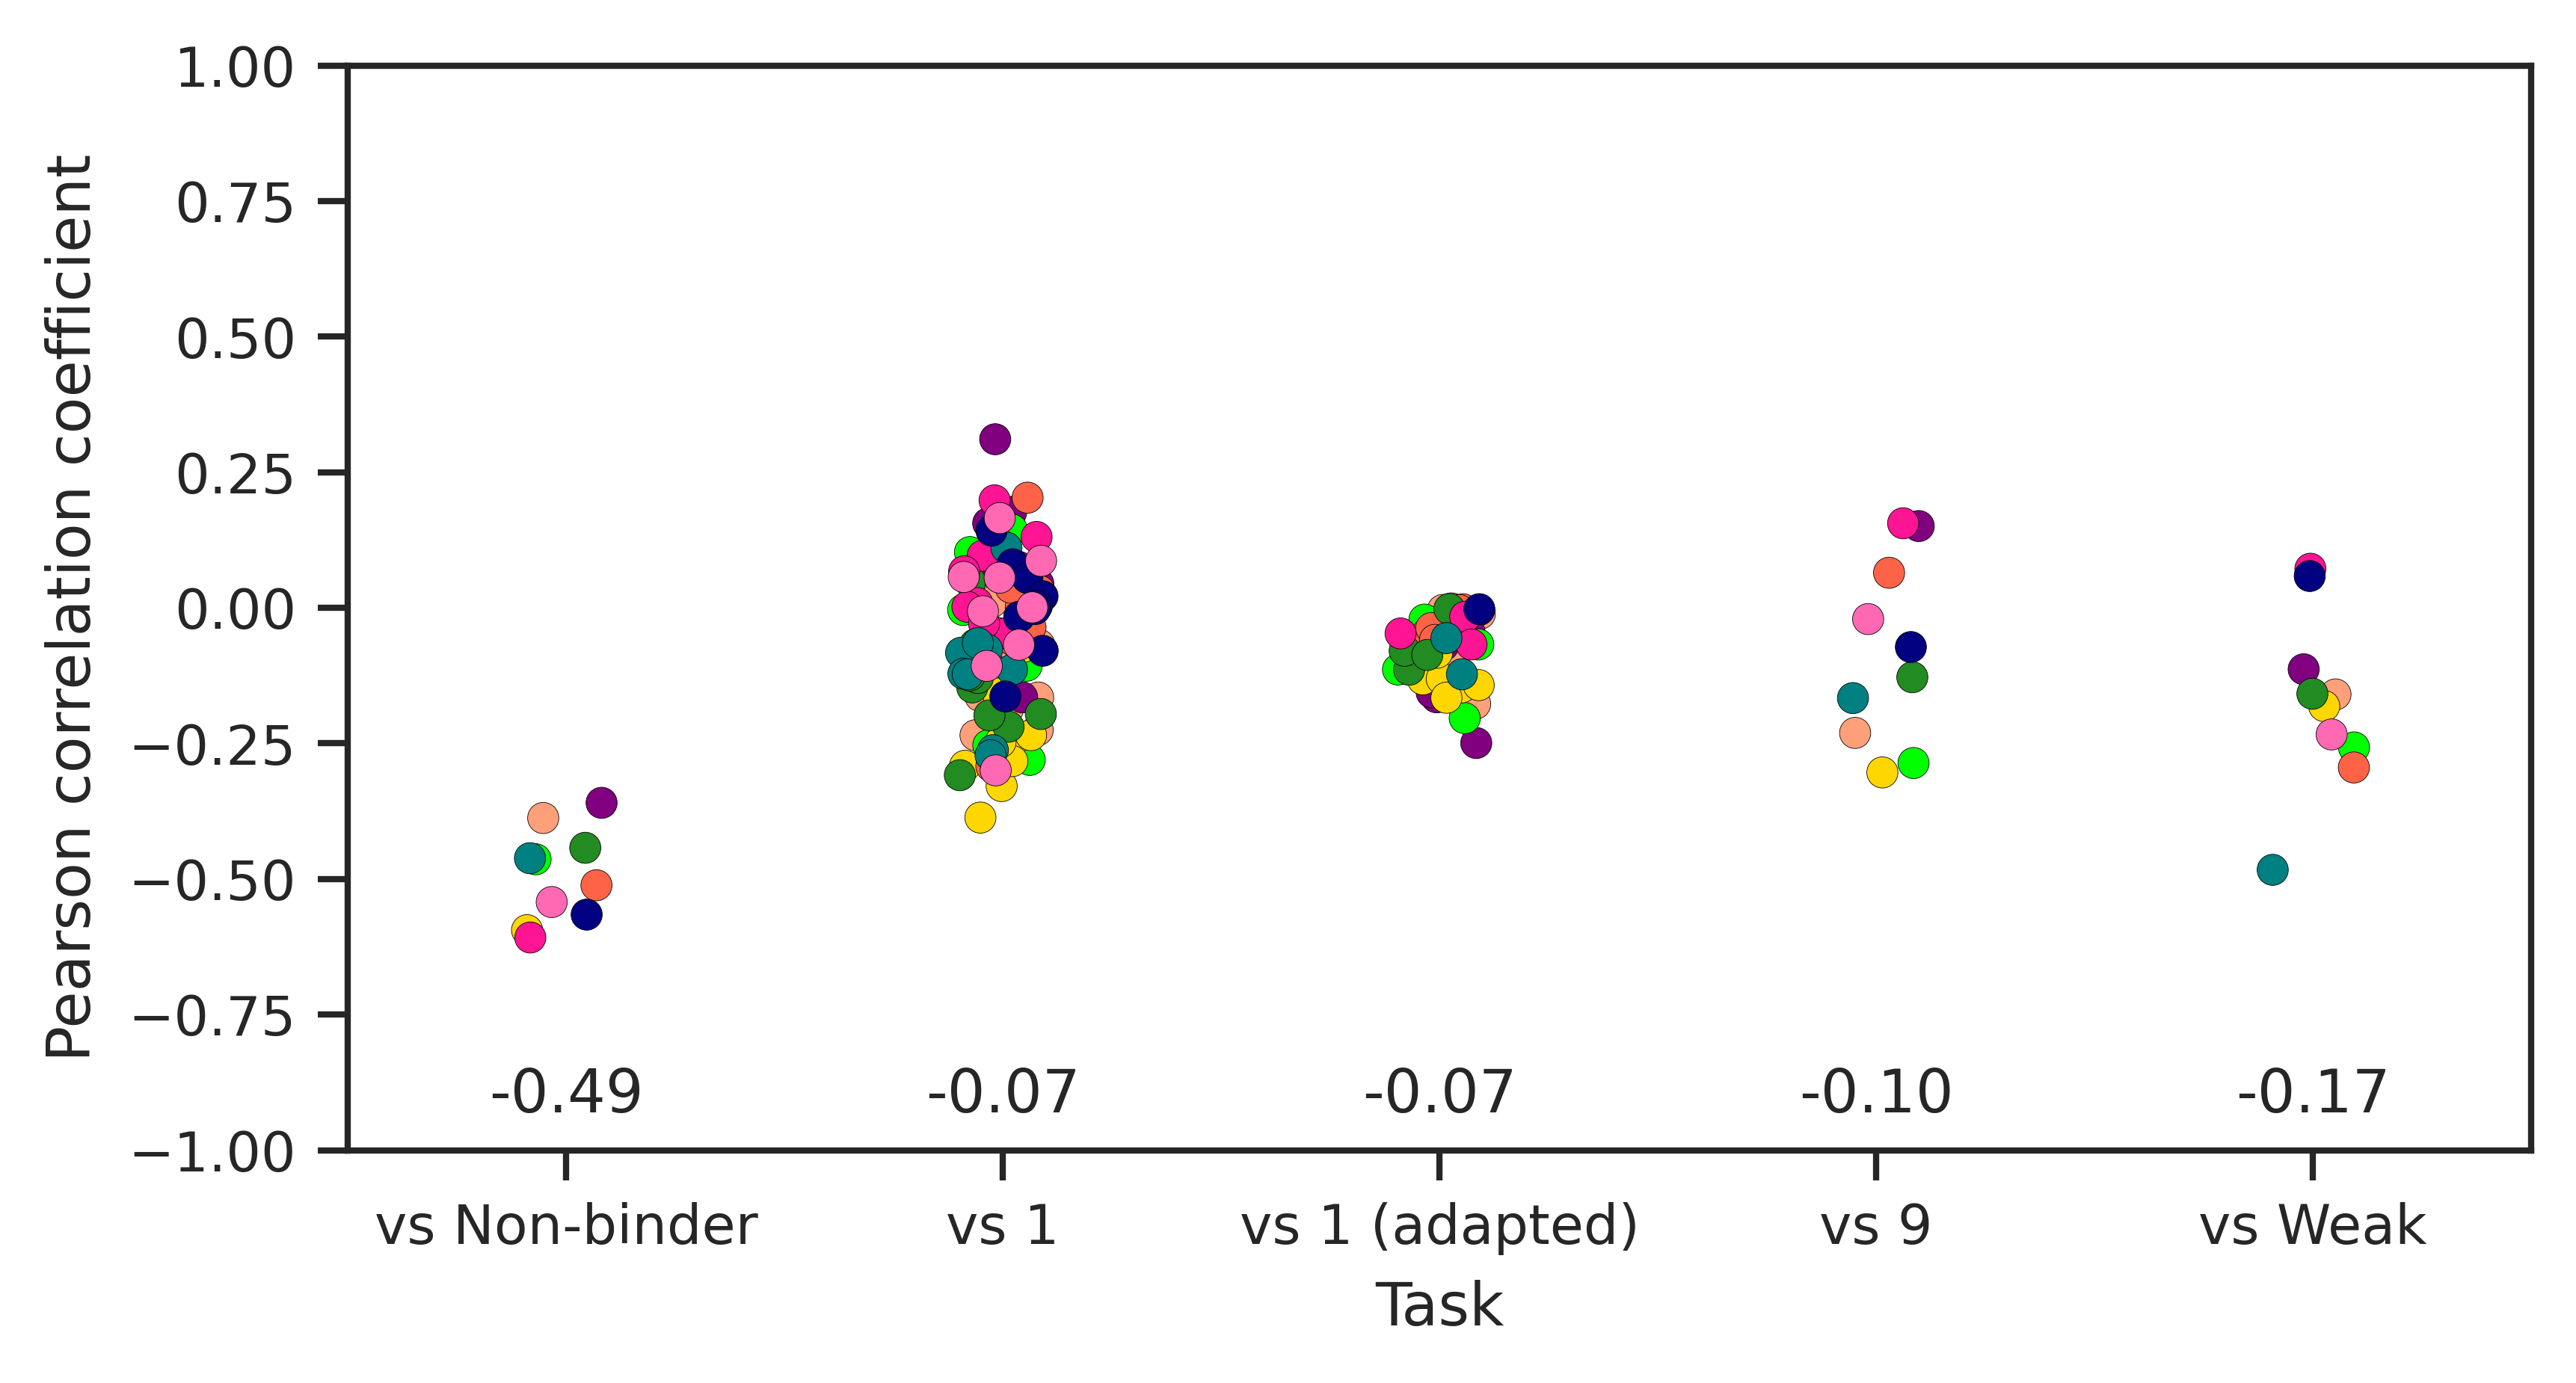

In [40]:
plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

palette = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'} 

# task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_order = ["high_vs_95low", "1v1", "1v1_adapted", "1v9", "high_vs_looser"]

sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    # cmap=visualisations.PlotParams.cmap_antigens,
    palette=palette,
    edgecolor = 'black',
    linewidth =  0.1,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.93,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
ax.set_ylim(-1, 1)

# Save fig as .svg
fig.savefig("figures/Supp_Figure_6_D.svg")

Plotting individual energy contributions correlations

In [48]:
def plot_energy_contributions_per_task(task, slide_class = "positive", plot_perc = False, ax = None):
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(
        task, 
        load_slide_df=True,
        attr_analysis_name="Test",
        attributor_name="DeepLIFT_LOCAL_Test",
        )
    all_energies = []
    all_energies_perc = []
    all_attrs = []
    all_attrs_perc = []

    for i, row in slide_df.iterrows():
        if row["class"] != slide_class:
            continue
        energies = row["energies"]
        all_energies += energies
        all_energies_perc += (np.array(energies) / np.sum(energies)).tolist()

        attrs = row["attributions"]
        all_attrs += attrs.tolist()
        all_attrs_perc += (np.array(attrs) / np.sum(np.abs(attrs))).tolist()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if plot_perc:
        ax.plot(
            all_attrs_perc, 
            all_energies_perc, 
            'o', 
            alpha=0.1,
            color="#f1593a", # red
            )
    else:
        ax.plot(all_attrs, all_energies, 'o', alpha=0.1)

    # Compute correlation and add text

    r, p = pearsonr(all_energies_perc, all_attrs_perc)
    r2 = r ** 2
    ax.text(
        0.23,
        0.03,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 0, 'Attribution (signed fraction)')

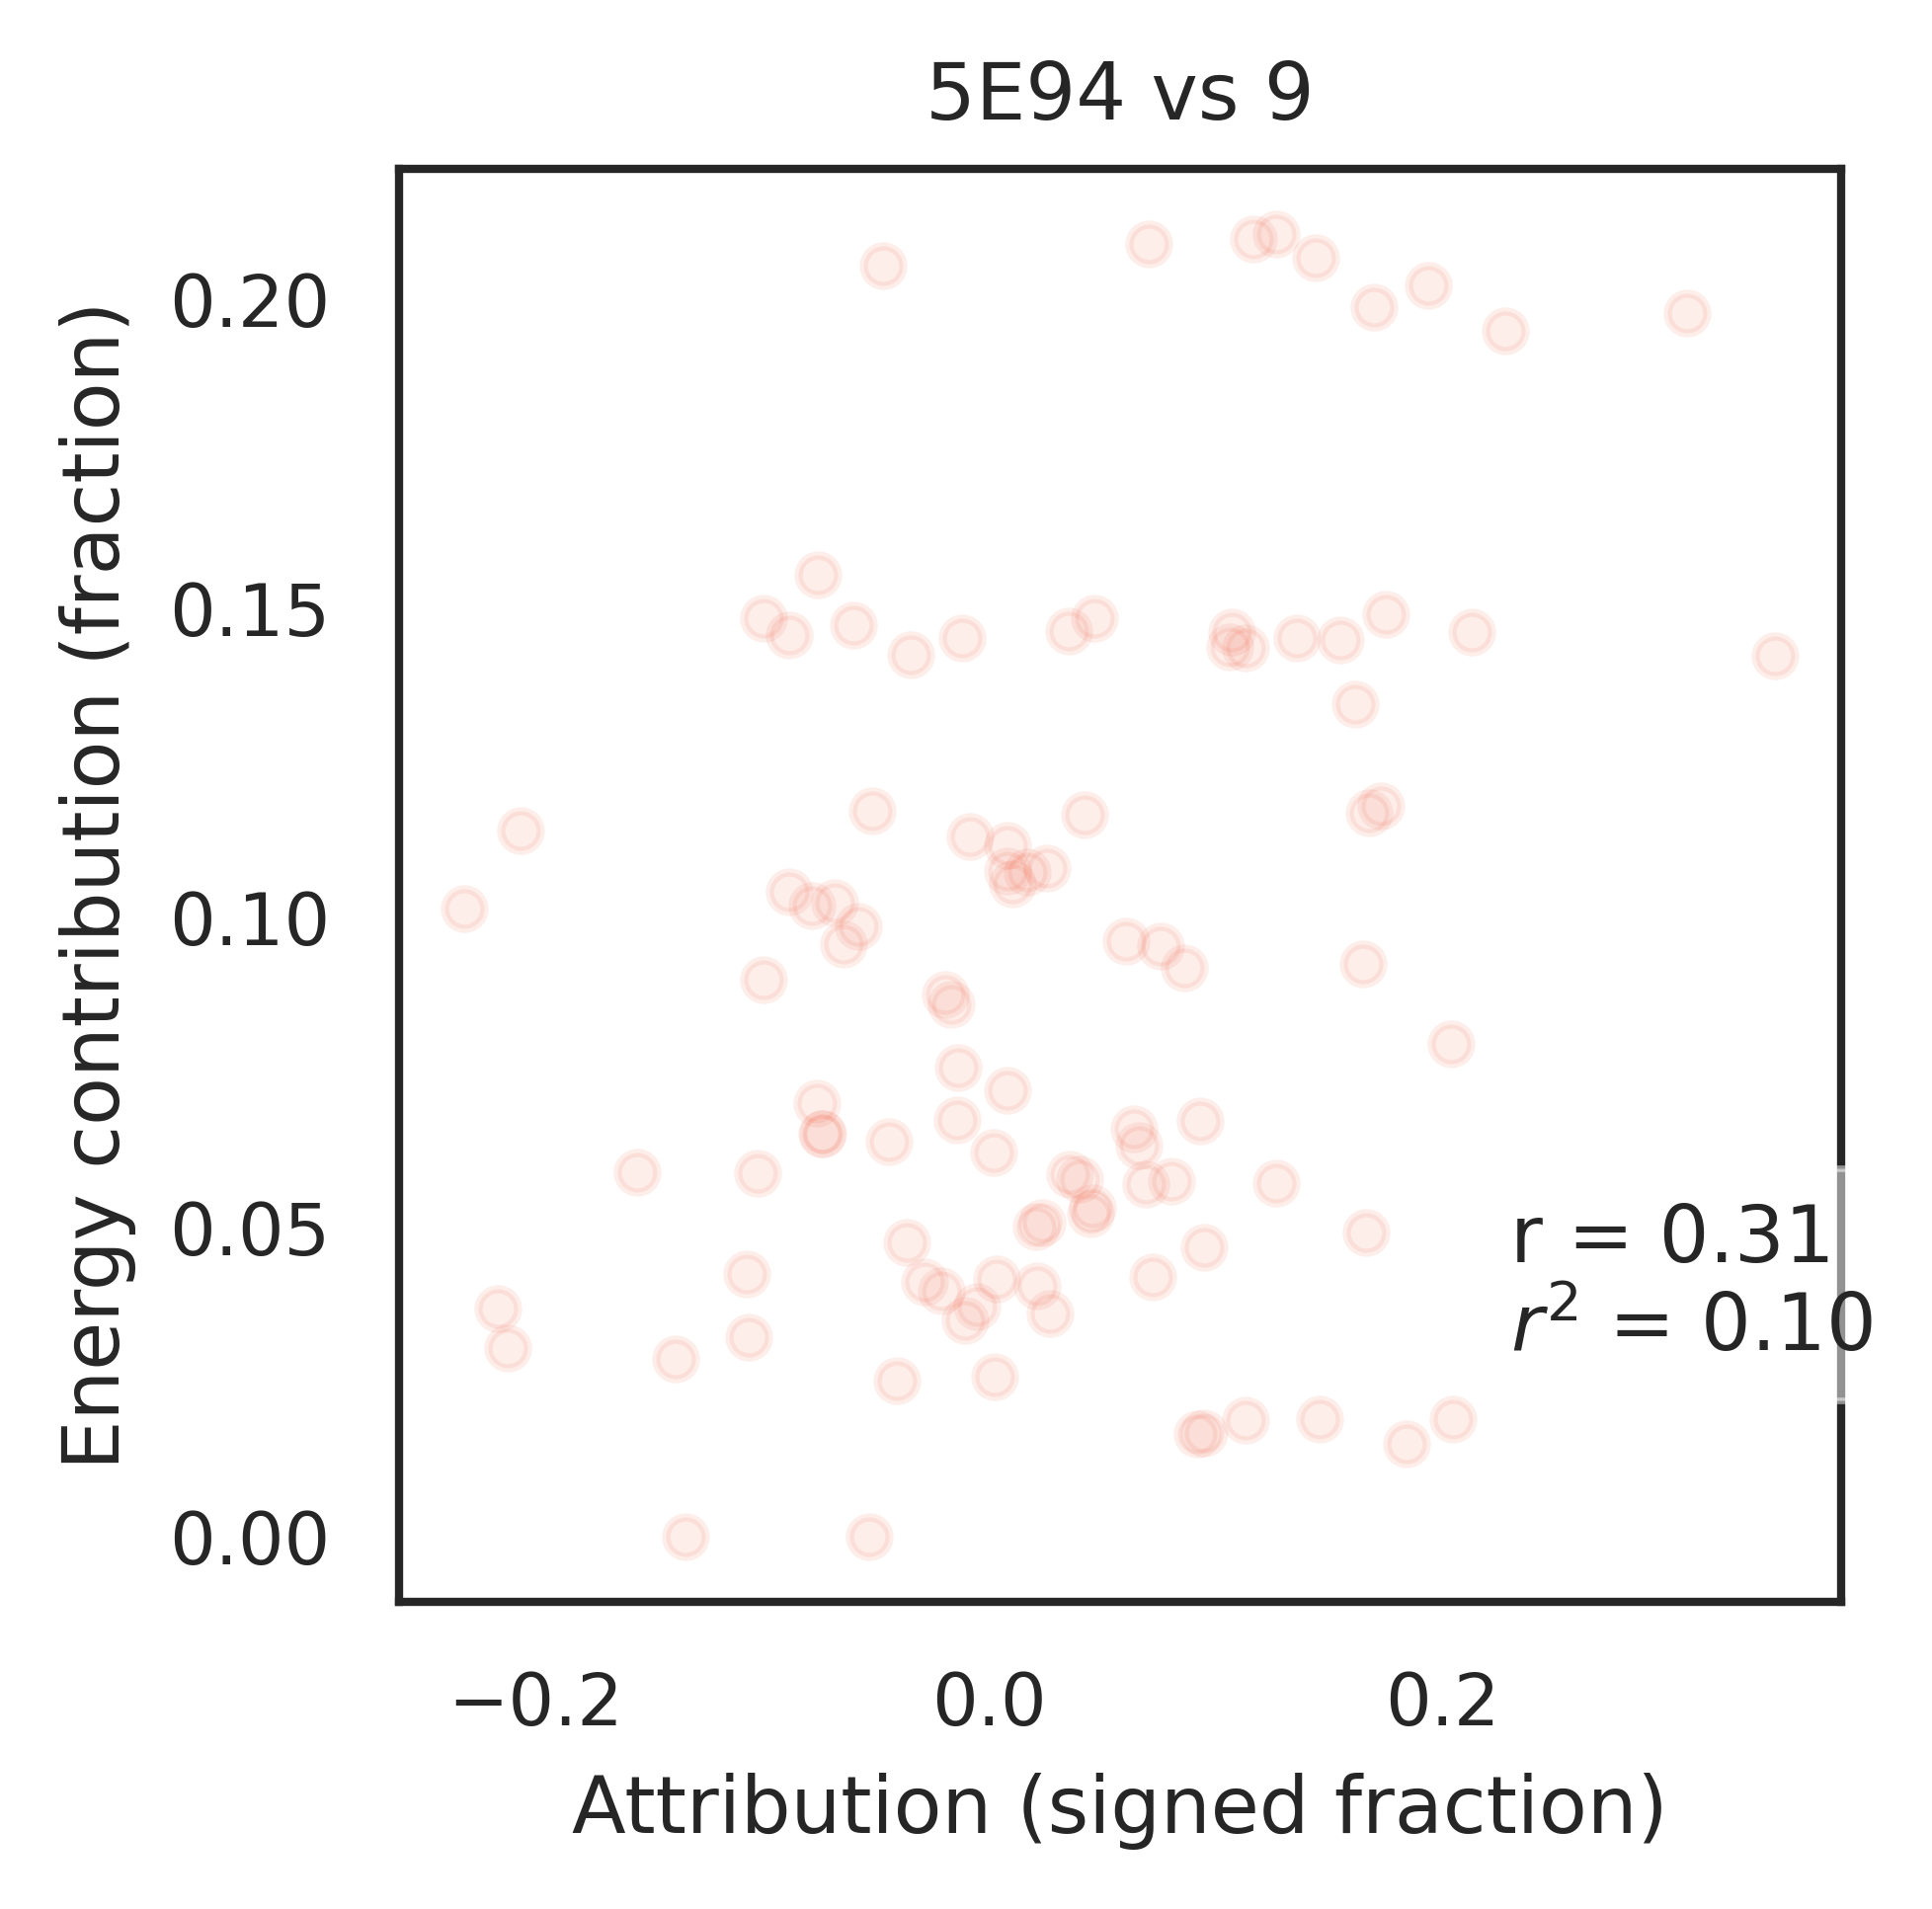

In [49]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")